- описание данных: https://www.kaggle.com/competitions/playground-series-s4e1/discussion/465045

- пример препроцессинга: https://www.kaggle.com/code/thomaskonstantin/bank-churn-data-exploration-and-churn-prediction

## Установка и загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Чтение данных

In [3]:
#raw_data = loadarff('EEG Eye State.arff')
df = pd.read_csv('/content/gdrive/MyDrive/hse/anonymization/lending_club_loan_two.csv')

In [4]:
print(df.shape)
df.head()

(396030, 27)


loan_amnt        term  int_rate  installment grade sub_grade  \
0    10000.0   36 months     11.44       329.48     B        B4   
1     8000.0   36 months     11.99       265.68     B        B5   
2    15600.0   36 months     10.49       506.97     B        B3   
3     7200.0   36 months      6.49       220.65     A        A2   
4    24375.0   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  ...  \
0                Marketing  10+ years           RENT    117000.0  ...   
1          Credit analyst     4 years       MORTGAGE     65000.0  ...   
2             Statistician   < 1 year           RENT     43057.0  ...   
3          Client Advocate    6 years           RENT     54000.0  ...   
4  Destiny Management Inc.    9 years       MORTGAGE     55000.0  ...   

  open_acc pub_rec revol_bal revol_util total_acc  initial_list_status  \
0     16.0     0.0   36369.0       41.8      25.0                    w   
1     17.0     0.0   20131.0       53.3      27.0                    f   
2     13.0     0.0   11987.0       92.2      26.0                    f   
3      6.0     0.0    5472.0       21.5      13.0                    f   
4     13.0     0.0   24584.0       69.8      43.0                    f   

  application_type  mort_acc  pub_rec_bankruptcies  \
0       INDIVIDUAL       0.0                   0.0   
1       INDIVIDUAL       3.0                   0.0   
2       INDIVIDUAL       0.0                   0.0   
3       INDIVIDUAL       0.0                   0.0   
4       INDIVIDUAL       1.0                   0.0   

                                             address  
0     0174 Michelle Gateway\r\nMendozaberg, OK 22690  
1  1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113  
2  87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113  
3            823 Reid Ford\r\nDelacruzside, MA 00813  
4             679 Luna Roads\r\nGreggshire, VA 11650  

[5 rows x 27 columns]

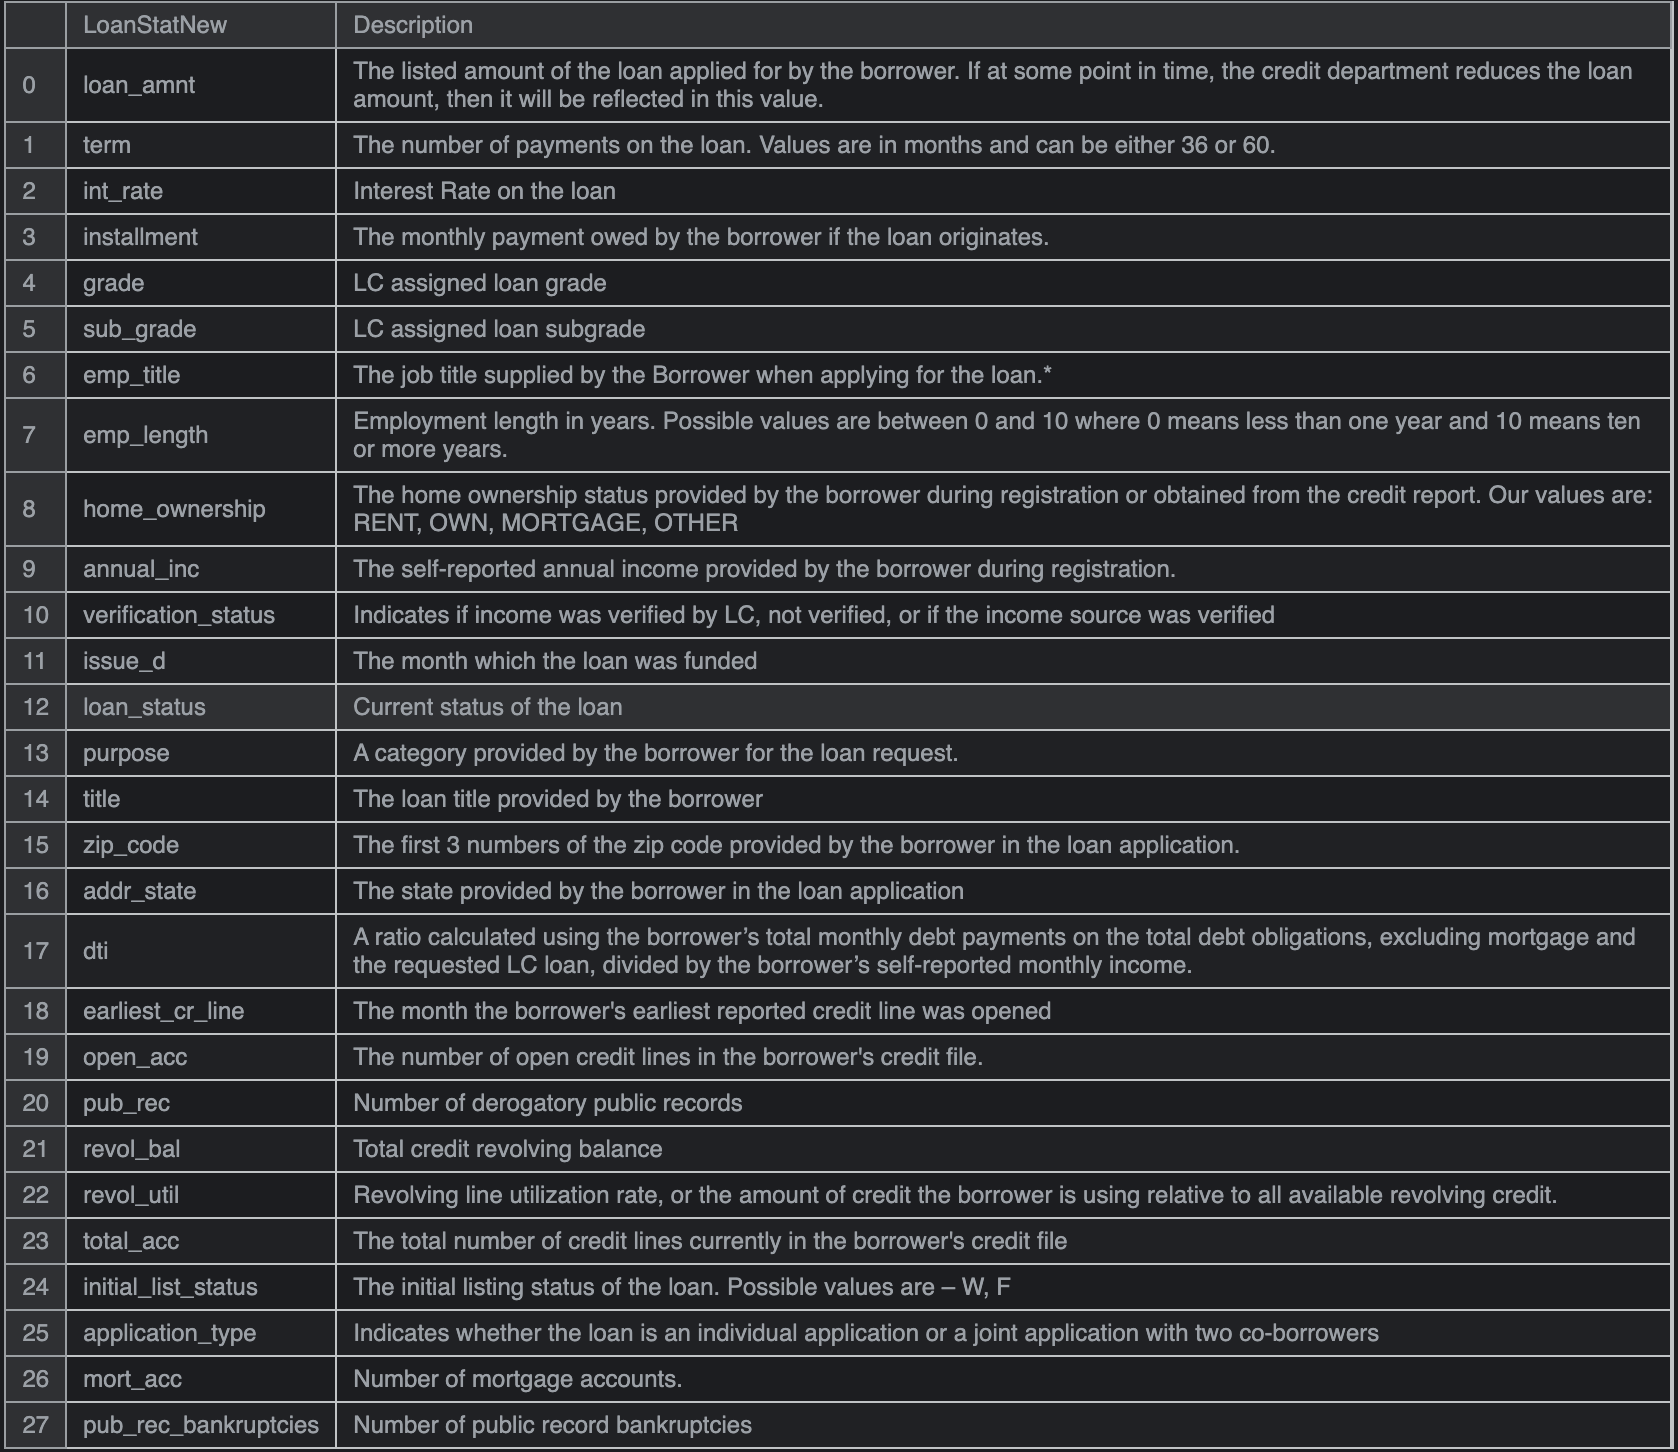

In [5]:
df.loan_status.value_counts()

loan_status
Fully Paid     318357
Charged Off     77673
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [7]:
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1756
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [8]:
# ANY + NONE -> other
df.loc[(df.home_ownership == 'ANY') | (df.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'
df.home_ownership.value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: count, dtype: int64

In [9]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

<ipython-input-9-fe846dc31369>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])
<ipython-input-9-fe846dc31369>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])


In [10]:
df['title'] = df.title.str.lower()

In [11]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [12]:
df['pub_rec'] = df.pub_rec.apply(pub_rec)
df['mort_acc'] = df.mort_acc.apply(mort_acc)
df['pub_rec_bankruptcies'] = df.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

In [13]:
df['loan_status'] = df.loan_status.map({'Fully Paid':1, 'Charged Off':0})

In [14]:
for column in df.columns:
    if df[column].isna().sum() != 0:
        missing = df[column].isna().sum()
        portion = (missing / df.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_title': number of missing values '22927' ==> '5.789%'
'emp_length': number of missing values '18301' ==> '4.621%'
'title': number of missing values '1756' ==> '0.443%'
'revol_util': number of missing values '276' ==> '0.070%'
'mort_acc': number of missing values '37795' ==> '9.543%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [15]:
# too much unique values, no additional info
df.drop('emp_title', axis=1, inplace=True)

In [16]:
for year in df.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{df[df.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('==========================================')

10+ years years in this position:
loan_status
1    0.815814
0    0.184186
Name: proportion, dtype: float64
4 years years in this position:
loan_status
1    0.807615
0    0.192385
Name: proportion, dtype: float64
< 1 year years in this position:
loan_status
1    0.793128
0    0.206872
Name: proportion, dtype: float64
6 years years in this position:
loan_status
1    0.810806
0    0.189194
Name: proportion, dtype: float64
9 years years in this position:
loan_status
1    0.79953
0    0.20047
Name: proportion, dtype: float64
2 years years in this position:
loan_status
1    0.806738
0    0.193262
Name: proportion, dtype: float64
3 years years in this position:
loan_status
1    0.804769
0    0.195231
Name: proportion, dtype: float64
8 years years in this position:
loan_status
1    0.80024
0    0.19976
Name: proportion, dtype: float64
7 years years in this position:
loan_status
1    0.805226
0    0.194774
Name: proportion, dtype: float64
5 years years in this position:
loan_status
1    0.80781

In [17]:
# distr of emp_length in target is same, no add info from feat
df.drop('emp_length', axis=1, inplace=True)

In [18]:
# useless cat feat
df.drop('title', axis=1, inplace=True)

In [19]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [20]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [21]:
total_acc_avg = df.groupby(by='total_acc').mort_acc.mean()

In [22]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [23]:
df.dropna(inplace=True)

In [24]:
df.shape

(395219, 24)

In [25]:
print([column for column in df.columns if df[column].dtype == object])

['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'address']


In [26]:
df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [27]:
term_values = {' 36 months': 36, ' 60 months': 60}
df['term'] = df.term.map(term_values)

In [28]:
# useless cat feat
df.drop('grade', axis=1, inplace=True)

In [29]:
# make cat feats numeric
dummies = ['verification_status', 'purpose', 'initial_list_status',
           'application_type', 'home_ownership']
df = pd.get_dummies(df, columns=dummies, dtype = 'int64', drop_first=True)

In [30]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(dtype = 'int64')
df[['sub_grade']] = enc.fit_transform(df[['sub_grade']])

In [31]:
df.address.head()

0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: address, dtype: object

In [32]:
# take only region (?) from adress
df['zip_code'] = df.address.apply(lambda x: x[-5:])

In [33]:
df.zip_code.value_counts()

zip_code
70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: count, dtype: int64

In [34]:
df = pd.get_dummies(df, columns=['zip_code'], dtype = 'int64', drop_first=True)

In [35]:
df.drop('address', axis=1, inplace=True)

In [36]:
df.drop('issue_d', axis=1, inplace=True)

In [37]:
df['earliest_cr_line'] = df.earliest_cr_line.dt.year

In [38]:
df.loan_status.value_counts(normalize=True)

loan_status
1    0.803848
0    0.196152
Name: proportion, dtype: float64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395219 entries, 0 to 396029
Data columns (total 46 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            395219 non-null  float64
 1   term                                 395219 non-null  int64  
 2   int_rate                             395219 non-null  float64
 3   installment                          395219 non-null  float64
 4   sub_grade                            395219 non-null  int64  
 5   annual_inc                           395219 non-null  float64
 6   loan_status                          395219 non-null  int64  
 7   dti                                  395219 non-null  float64
 8   earliest_cr_line                     395219 non-null  int32  
 9   open_acc                             395219 non-null  float64
 10  pub_rec                              395219 non-null  int64  
 11  revol_bal         

In [40]:
df.head().iloc[:, :20]

loan_amnt  term  int_rate  installment  sub_grade  annual_inc  loan_status  \
0    10000.0    36     11.44       329.48          8    117000.0            1   
1     8000.0    36     11.99       265.68          9     65000.0            1   
2    15600.0    36     10.49       506.97          7     43057.0            1   
3     7200.0    36      6.49       220.65          1     54000.0            1   
4    24375.0    60     17.27       609.33         14     55000.0            0   

     dti  earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  \
0  26.24              1990      16.0        0    36369.0        41.8   
1  22.05              2004      17.0        0    20131.0        53.3   
2  12.79              2007      13.0        0    11987.0        92.2   
3   2.60              2006       6.0        0     5472.0        21.5   
4  33.95              1999      13.0        0    24584.0        69.8   

   total_acc  mort_acc  pub_rec_bankruptcies  \
0       25.0       0.0                   0.0   
1       27.0       1.0                   0.0   
2       26.0       0.0                   0.0   
3       13.0       0.0                   0.0   
4       43.0       1.0                   0.0   

   verification_status_Source Verified  verification_status_Verified  \
0                                    0                             0   
1                                    0                             0   
2                                    1                             0   
3                                    0                             0   
4                                    0                             1   

   purpose_credit_card  purpose_debt_consolidation  
0                    0                           0  
1                    0                           1  
2                    1                           0  
3                    1                           0  
4                    1                           0

<Axes: >

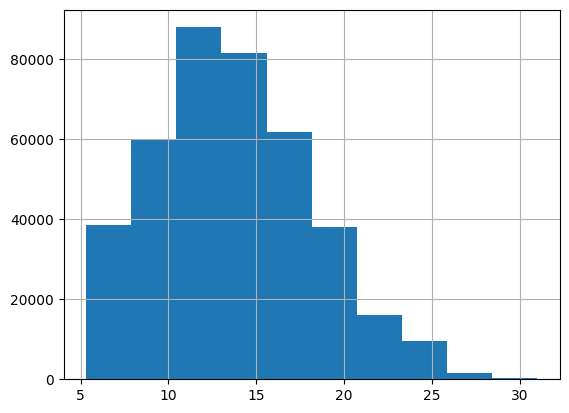

In [41]:
df.int_rate.hist()

<Axes: >

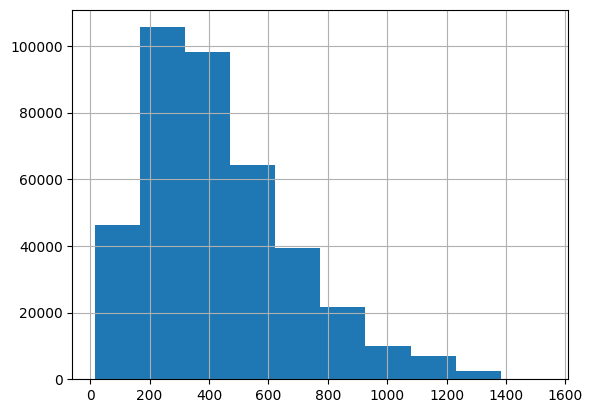

In [42]:
df.installment.hist()

<ipython-input-43-d559fe43a2d9>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.annual_inc)


<Axes: xlabel='annual_inc', ylabel='Density'>

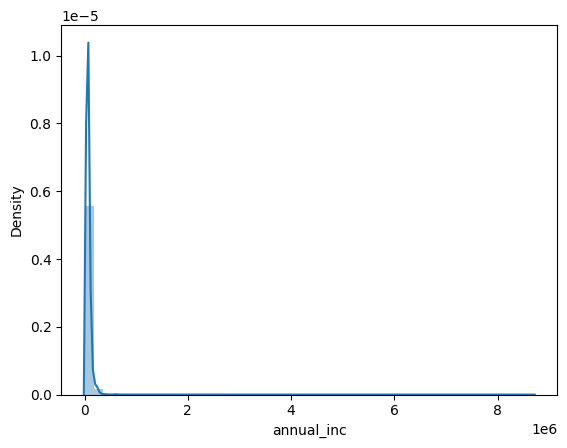

In [43]:
sns.distplot(df.annual_inc)

In [44]:
df.annual_inc.quantile(0.999)

np.float64(510000.0)

In [45]:
print(df.shape)
df = df[df.annual_inc < df.annual_inc.quantile(0.999)]
print(df.shape)

(395219, 46)
(394822, 46)


<Axes: >

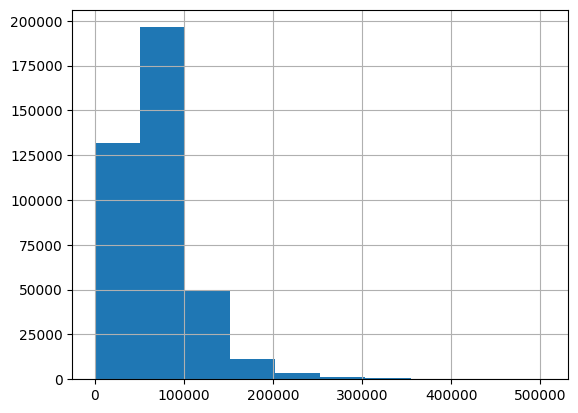

In [46]:
df.annual_inc.hist()

In [47]:
print(df.shape)
df = df[df.dti < df.dti.quantile(0.999)]
print(df.shape)

(394822, 46)
(394424, 46)


<Axes: >

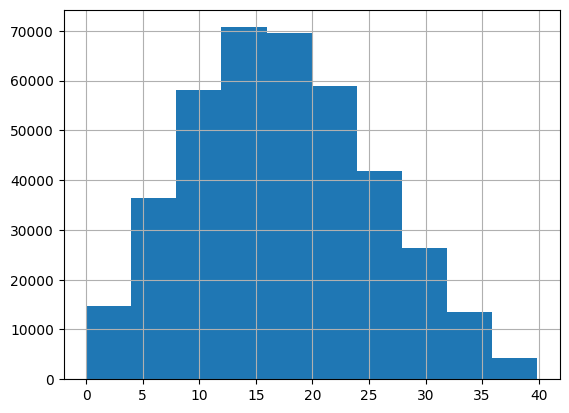

In [48]:
df.dti.hist()

In [49]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(dtype = 'int64')
df[['earliest_cr_line']] = enc.fit_transform(df[['earliest_cr_line']])

<Axes: >

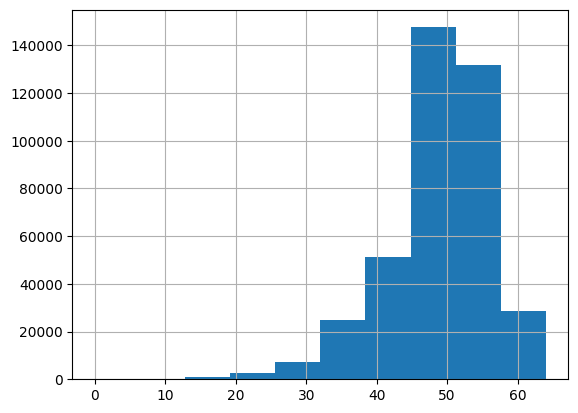

In [50]:
df.earliest_cr_line.hist()

<Axes: >

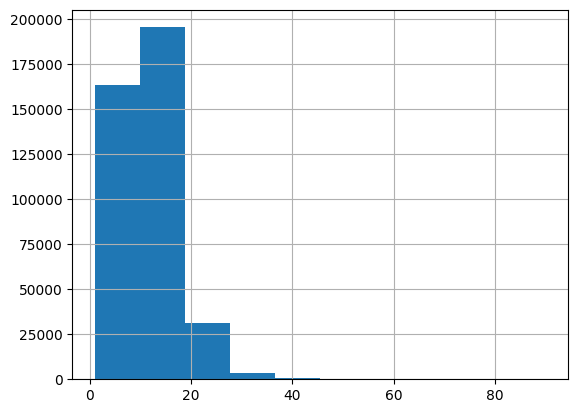

In [51]:
df.open_acc.hist()

<Axes: >

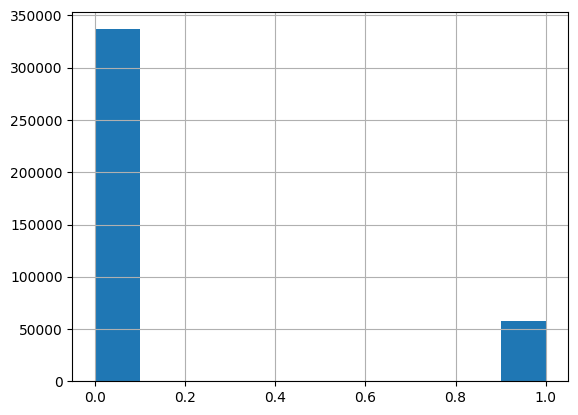

In [52]:
df.pub_rec.hist()

In [53]:
df = df[df.revol_bal < df.revol_bal.quantile(0.999)]

<Axes: >

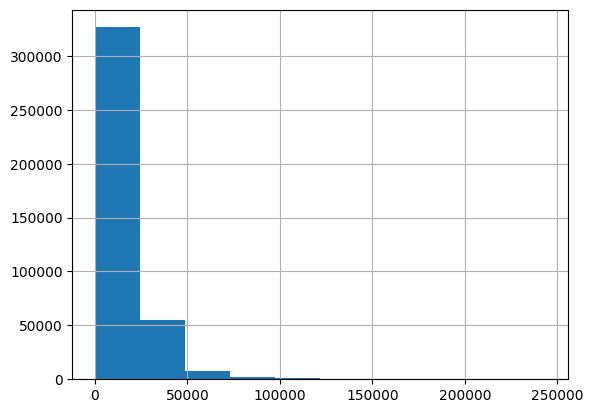

In [54]:
df.revol_bal.hist()

<Axes: >

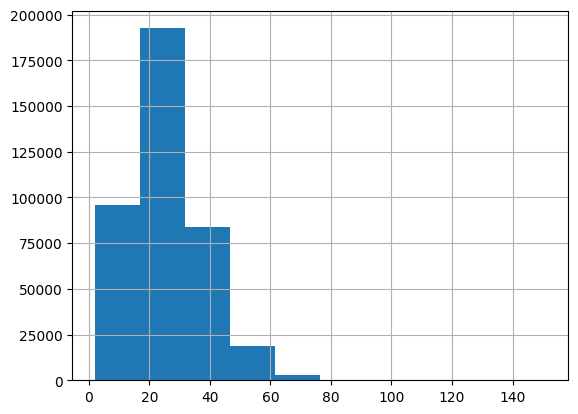

In [55]:
df.total_acc.hist()

In [56]:
df.mort_acc = df.mort_acc.astype('int64')
df.pub_rec_bankruptcies = df.pub_rec_bankruptcies.astype('int64')

In [57]:
df.isna().sum().sum()

np.int64(0)

In [58]:
df.head()

loan_amnt  term  int_rate  installment  sub_grade  annual_inc  loan_status  \
0    10000.0    36     11.44       329.48          8    117000.0            1   
1     8000.0    36     11.99       265.68          9     65000.0            1   
2    15600.0    36     10.49       506.97          7     43057.0            1   
3     7200.0    36      6.49       220.65          1     54000.0            1   
4    24375.0    60     17.27       609.33         14     55000.0            0   

     dti  earliest_cr_line  open_acc  ...  home_ownership_RENT  \
0  26.24                41      16.0  ...                    1   
1  22.05                55      17.0  ...                    0   
2  12.79                58      13.0  ...                    1   
3   2.60                57       6.0  ...                    1   
4  33.95                50      13.0  ...                    0   

   zip_code_05113  zip_code_11650  zip_code_22690  zip_code_29597  \
0               0               0               1               0   
1               1               0               0               0   
2               1               0               0               0   
3               0               0               0               0   
4               0               1               0               0   

   zip_code_30723  zip_code_48052  zip_code_70466  zip_code_86630  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   zip_code_93700  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 46 columns]

In [59]:
from matplotlib import pyplot
import seaborn as sns

In [60]:
#scaler = StandardScaler()

In [61]:
X = df.drop(columns = 'loan_status')
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [62]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [63]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train, y_train)

#y_pred = lgb_1.predict(X_test)

# evaluation
#print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 253345, number of negative: 61878
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 315223, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803701 -> initscore=1.409587
[LightGBM] [Info] Start training from score 1.409587


LGBMClassifier()

In [64]:
preds = lgb_1.predict(X_test)
proba = lgb_1.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, preds)
print(accuracy)
f1 = f1_score(y_test, preds)
print(f1)
precision = precision_score(y_test, preds)
print(precision)
recall = recall_score(y_test, preds)
print(recall)
auc = roc_auc_score(y_test, proba)
print(auc)

0.8899703068294292
0.9355905008802359
0.8841839241839242
0.9933436386005867
0.9090256664723086


In [65]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8

In [66]:
X_train_cut = X_train
y_train_cut = y_train

In [67]:
X_train_cut.shape

(315223, 45)

In [68]:
syn_data = pd.concat([X_train_cut, y_train_cut], axis = 1)

In [69]:
syn_data.head()

loan_amnt  term  int_rate  installment  sub_grade  annual_inc    dti  \
270806    21000.0    36     13.98       717.53         12     90000.0  11.76   
235133     5000.0    36      6.03       152.18          0     80000.0   0.54   
358415    20000.0    36     10.99       654.68          6     95000.0  15.07   
153255    10900.0    36     14.99       377.80         14     36000.0  30.00   
340346    20000.0    60     13.99       465.27         12     65000.0  21.52   

        earliest_cr_line  open_acc  pub_rec  ...  zip_code_05113  \
270806                47       7.0        0  ...               0   
235133                47       8.0        0  ...               0   
358415                32      11.0        0  ...               0   
153255                45      16.0        0  ...               1   
340346                55      14.0        0  ...               0   

        zip_code_11650  zip_code_22690  zip_code_29597  zip_code_30723  \
270806               0               0               1               0   
235133               0               0               0               0   
358415               0               0               1               0   
153255               0               0               0               0   
340346               0               0               1               0   

        zip_code_48052  zip_code_70466  zip_code_86630  zip_code_93700  \
270806               0               0               0               0   
235133               0               1               0               0   
358415               0               0               0               0   
153255               0               0               0               0   
340346               0               0               0               0   

        loan_status  
270806            1  
235133            1  
358415            1  
153255            1  
340346            1  

[5 rows x 46 columns]

In [70]:
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer

metadata = Metadata.detect_from_dataframe(data=syn_data)

In [ ]:
synthesizer = CTGANSynthesizer(
    metadata, # required
    enforce_rounding=False,
    epochs=100,
    verbose=True
)

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:104: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [ ]:
synthesizer.fit(syn_data)

Gen. (-1.44) | Discrim. (0.20): 100%|██████████| 143/143 [5:31:24<00:00, 139.05s/it]


In [ ]:
synthesizer.save('synthesizer_2803_new_all.pkl')

In [71]:
import pickle


with open('synthesizer_2803_new_all.pkl', 'rb') as f:
    synthesizer = pickle.load(f)

In [72]:
fig = synthesizer.get_loss_values_plot()
fig.show()

In [73]:
synthesizer.get_parameters()

{'enforce_min_max_values': True,
 'enforce_rounding': False,
 'locales': ['en_US'],
 'embedding_dim': 128,
 'generator_dim': (256, 256),
 'discriminator_dim': (256, 256),
 'generator_lr': 0.0002,
 'generator_decay': 1e-06,
 'discriminator_lr': 0.0002,
 'discriminator_decay': 1e-06,
 'batch_size': 500,
 'discriminator_steps': 1,
 'log_frequency': True,
 'verbose': True,
 'epochs': 100,
 'pac': 10,
 'cuda': True}

In [74]:
synthetic_data = synthesizer.sample(num_rows=syn_data.shape[0])

In [75]:
synthetic_data.head()

loan_amnt  term   int_rate  installment  sub_grade    annual_inc  \
0   7440.480210    36   6.750772   194.980522          8  48143.483410   
1  16487.320059    60  15.419865   713.951310          8  90011.437690   
2  30646.689782    36  10.867487  1037.007777         16  97934.628083   
3   5645.132189    36   7.726753   231.528260          1  40207.034520   
4  16030.931400    36  18.306470   294.122725         28  34139.484682   

         dti  earliest_cr_line   open_acc  pub_rec  ...  zip_code_05113  \
0   9.669041                49   4.673245        0  ...           14393   
1  14.033669                39  11.741472        0  ...            7370   
2  19.150309                42  18.261879        1  ...           72044   
3  20.310490                47  19.130250        1  ...           57634   
4   9.953721                51   8.887875        0  ...           52100   

   zip_code_11650  zip_code_22690  zip_code_29597  zip_code_30723  \
0           64508           41066           87418           38214   
1           48282           60986           78291           18832   
2           12003           16608           48031           88770   
3           64459           56413           48609           65590   
4           55264           80174           86653            5635   

   zip_code_48052  zip_code_70466  zip_code_86630  zip_code_93700  loan_status  
0            6409           93246           31486           52487            1  
1           75130           84893           10336            3627            1  
2           98098           50718           79095           17778            1  
3           34137           53502           59470           73672            1  
4           94167           39879           90802           11961            1  

[5 rows x 46 columns]

In [76]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [77]:
#синтетические данные
X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(synthetic_data.drop(columns = 'loan_status'),
                                                                    synthetic_data[['loan_status']], random_state = 44)

In [78]:
#реальные данные
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_train_cut, y_train_cut, random_state = 44)

In [79]:
from sklearn.tree import DecisionTreeClassifier

cls = DecisionTreeClassifier()
cls.fit(X_train_real, y_train_real)

preds = cls.predict(X_test_real)
proba = cls.predict_proba(X_test_real)[:, 1]

accuracy = accuracy_score(y_test_real, preds)
print(accuracy)
f1 = f1_score(y_test_real, preds)
print(f1)
precision = precision_score(y_test_real, preds)
print(precision)
recall = recall_score(y_test_real, preds)
print(recall)
auc = roc_auc_score(y_test_real, proba)
print(auc)

0.8289977920462909
0.8929881680298578
0.8995888197366526
0.8864836741450802
0.7391973608387147


In [80]:
#классификатор для обучения на синтетических данных
cls_synth = DecisionTreeClassifier()
cls_synth.fit(X_train_gen, y_train_gen)

preds_gen = cls_synth.predict(X_test_gen)
proba_gen = cls_synth.predict_proba(X_test_gen)[:, 1]

accuracy_gen = accuracy_score(y_test_gen, preds_gen)
print(accuracy_gen)
f1_gen = f1_score(y_test_gen, preds_gen)
print(f1_gen)
precision_gen = precision_score(y_test_gen, preds_gen)
print(precision_gen)
recall_gen = recall_score(y_test_gen, preds_gen)
print(recall_gen)
auc_gen = roc_auc_score(y_test_gen, proba_gen)
print(auc_gen)

0.6714844047407558
0.7880782233573177
0.7954293834790225
0.780861694189404
0.5297082363720912


In [81]:
metrics = {'data': ['real', 'synthetic'], 'accuracy': [], 'precision': [], 'recall': [], 'F1 score': [], 'RocAuc': []}

In [82]:
metrics['recall'].append(recall)
metrics['recall'].append(recall_gen)

metrics['precision'].append(precision)
metrics['precision'].append(precision_gen)

metrics['RocAuc'].append(auc)
metrics['RocAuc'].append(auc_gen)

metrics['F1 score'].append(f1)
metrics['F1 score'].append(f1_gen)

metrics['accuracy'].append(accuracy)
metrics['accuracy'].append(accuracy_gen)

In [83]:
# new
pd.DataFrame(metrics)

data  accuracy  precision    recall  F1 score    RocAuc
0       real  0.828998   0.899589  0.886484  0.892988  0.739197
1  synthetic  0.671484   0.795429  0.780862  0.788078  0.529708

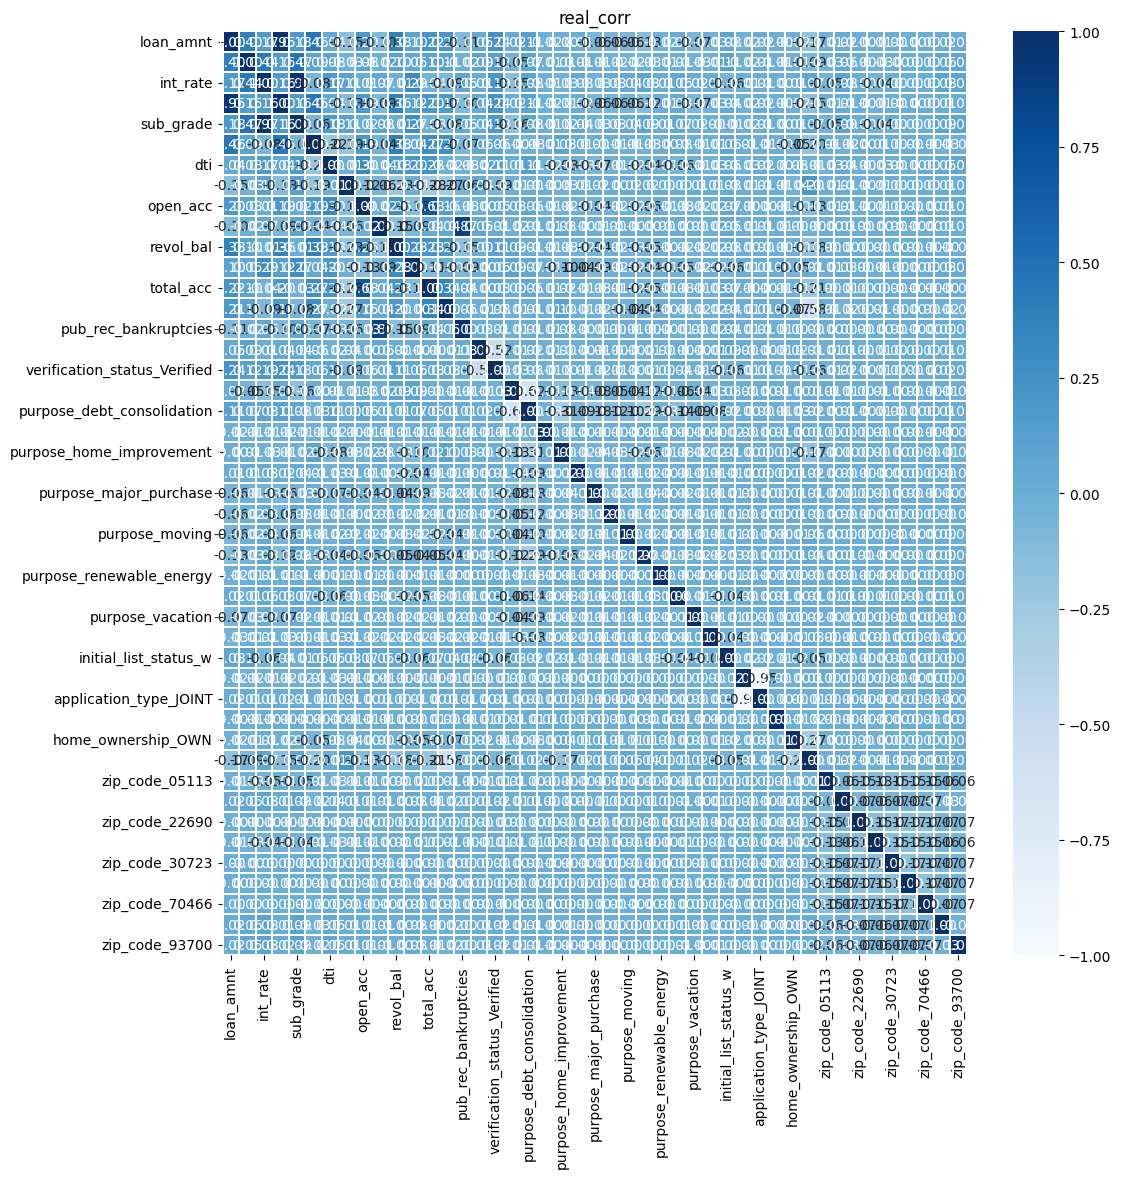

In [84]:
sns.heatmap(X_train_cut.corr(), annot=True, cmap="Blues", linewidths=0.2, vmin=-1, vmax=1, fmt=".2f")
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.title('real_corr')
plt.show()

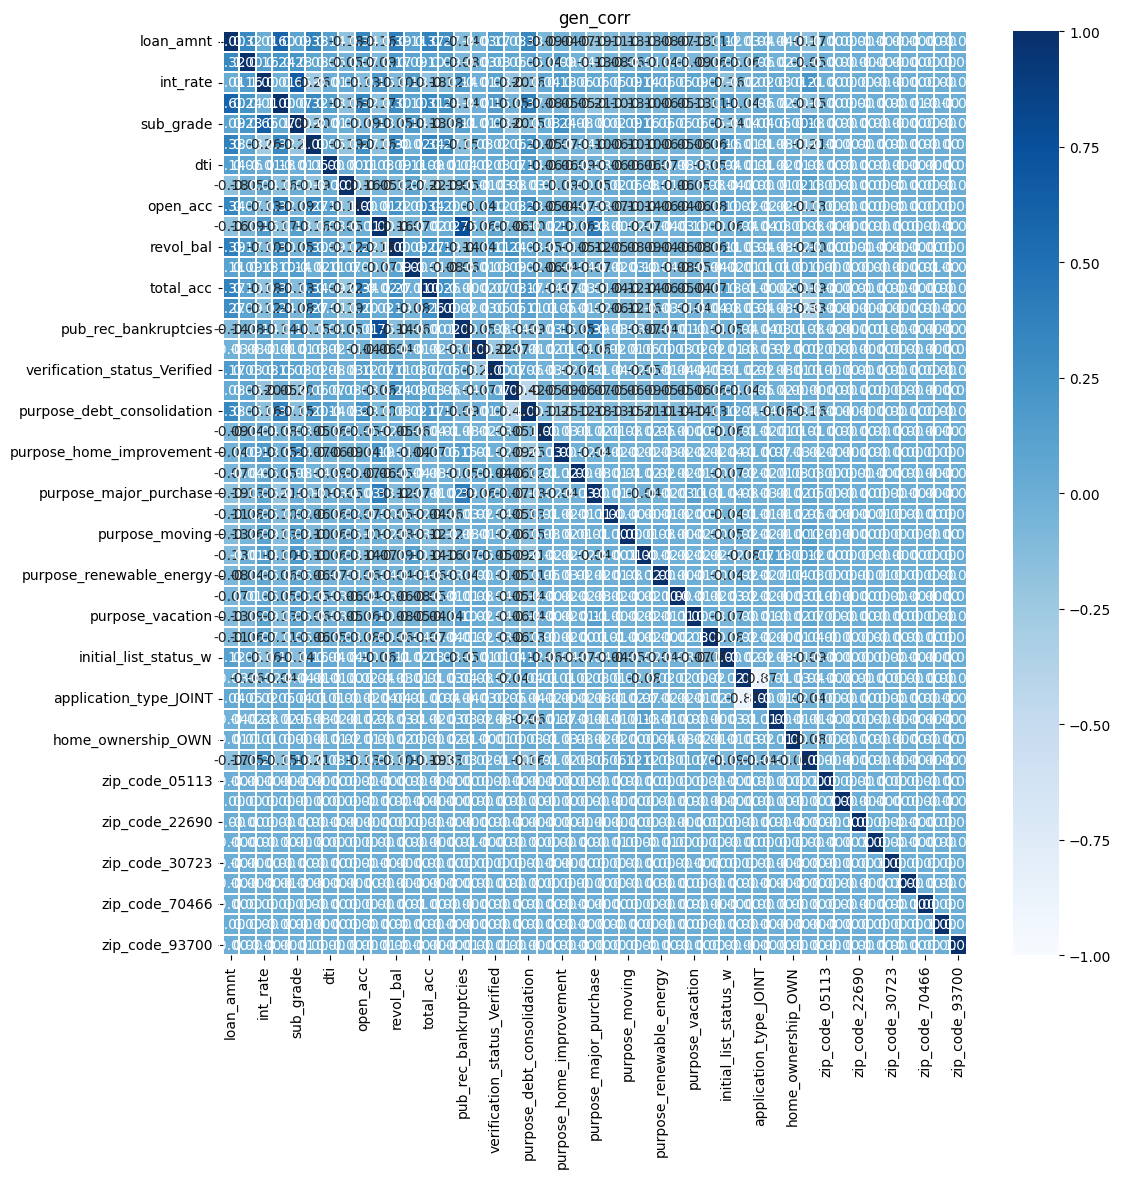

In [85]:
sns.heatmap(X_train_gen.corr(), annot=True, cmap="Blues", linewidths=0.2, vmin=-1, vmax=1, fmt=".2f")
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.title('gen_corr')
plt.show()

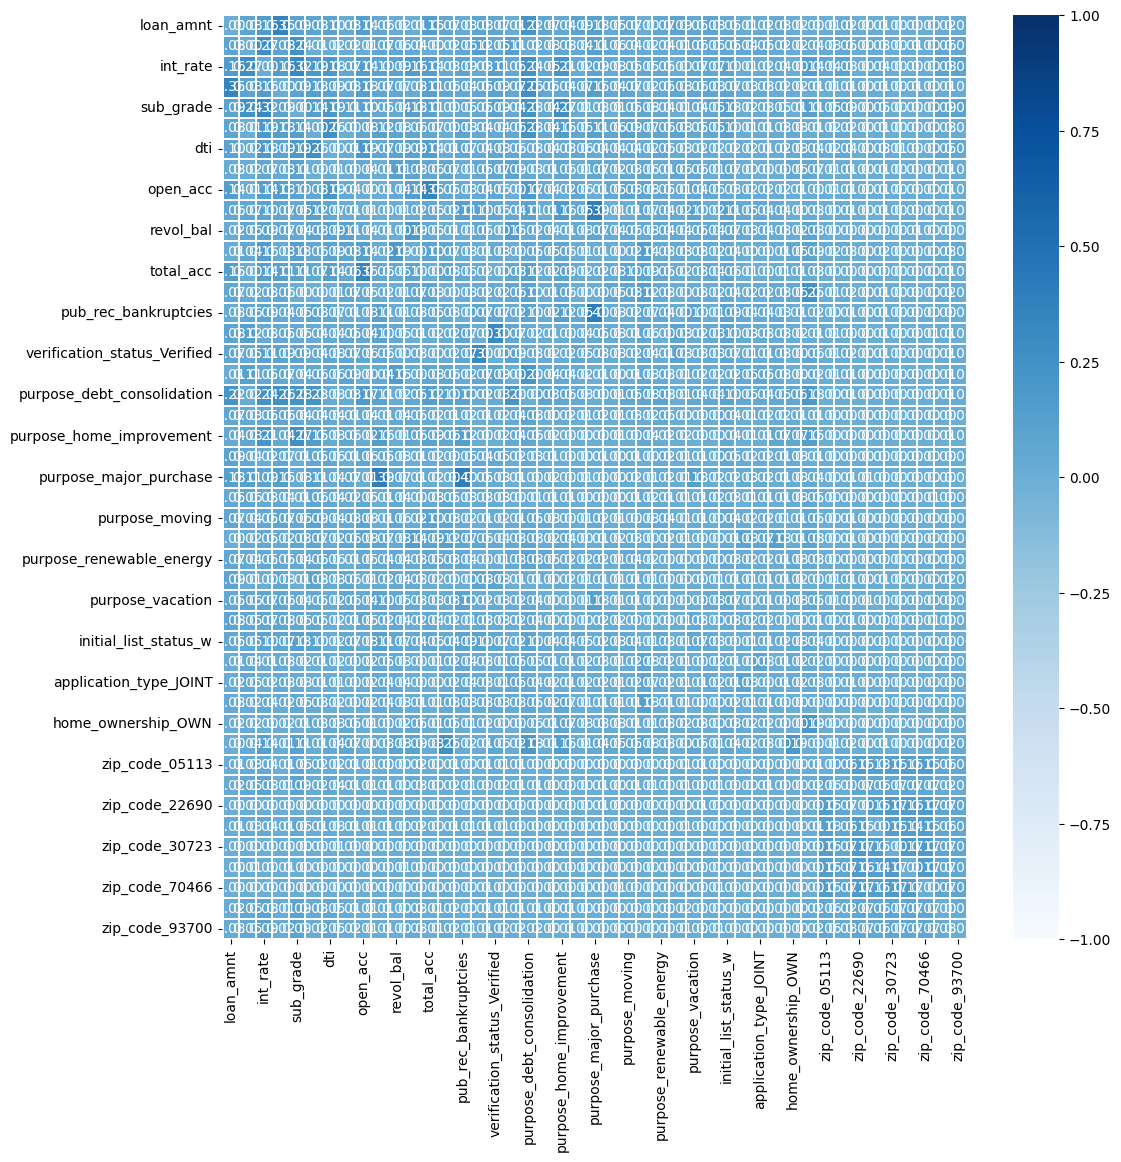

In [86]:
sns.heatmap(abs(X_train_cut.corr() - X_train_gen.corr()), annot=True, cmap="Blues", linewidths=0.2, vmin=-1, vmax=1, fmt=".2f")
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.show()

In [109]:
cont_columns = ['loan_amnt', 'int_rate', 'installment', 'sub_grade',
                'annual_inc', 'dti', 'earliest_cr_line', 'open_acc',
                'revol_bal', 'revol_util', 'total_acc']
discrete_columns = list(set(X_train_cut.columns) ^ set(cont_columns))

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



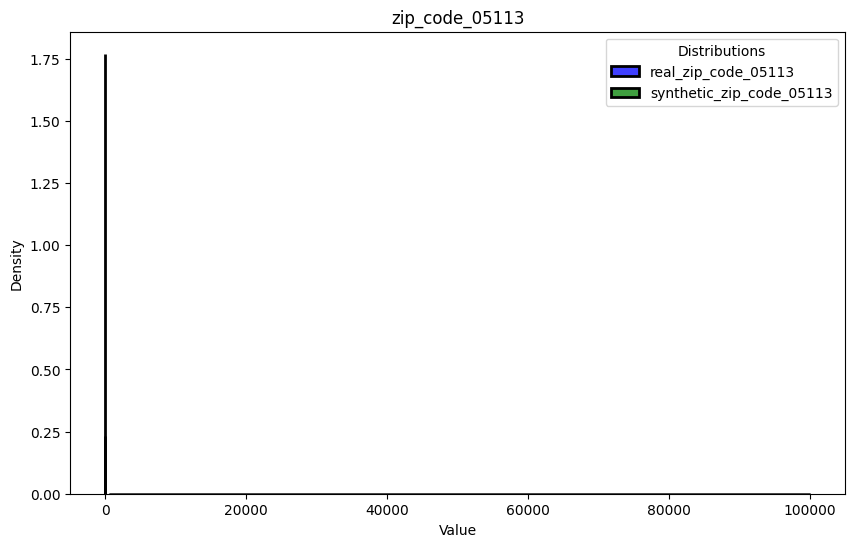

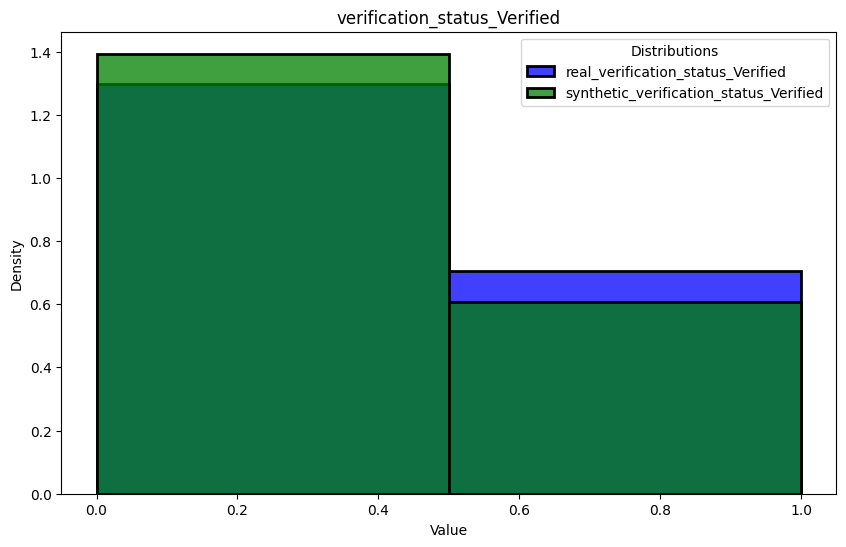

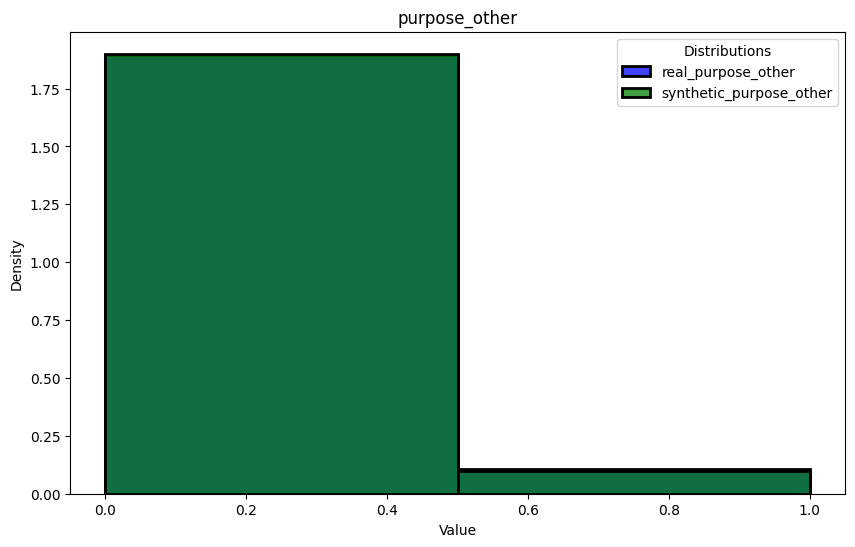

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



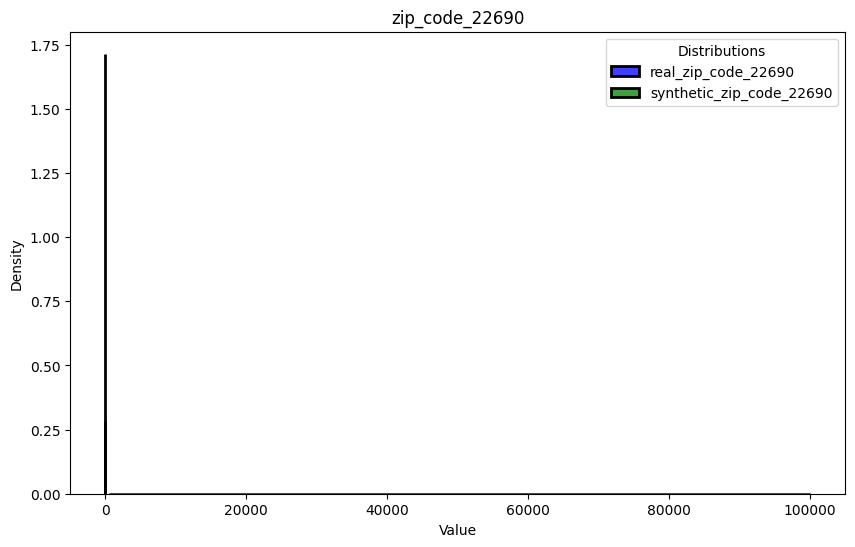

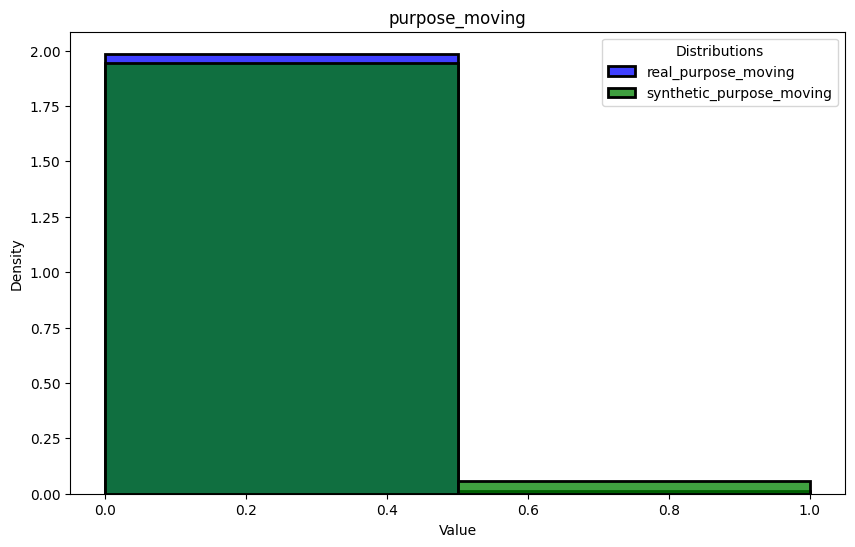

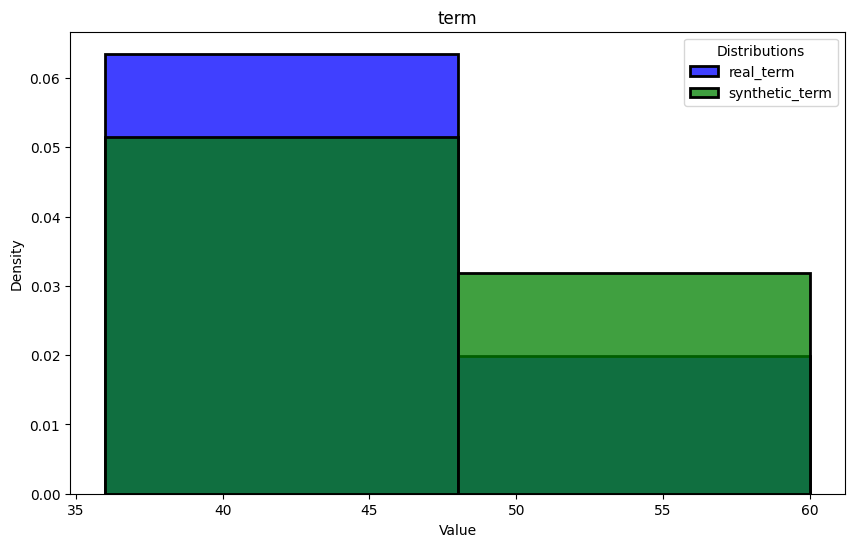

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



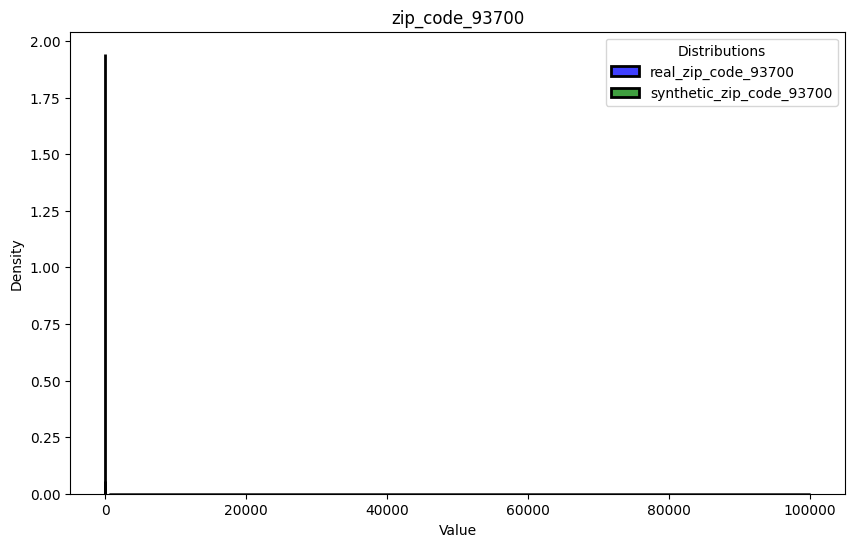

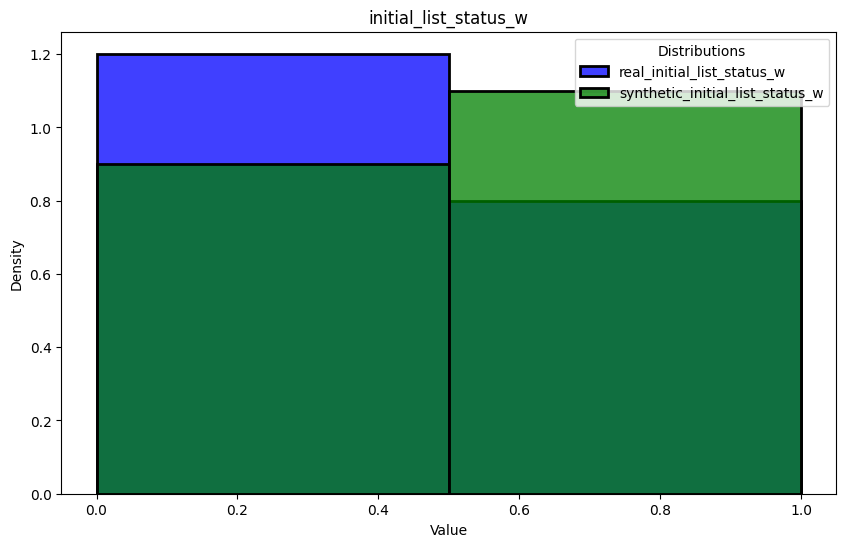

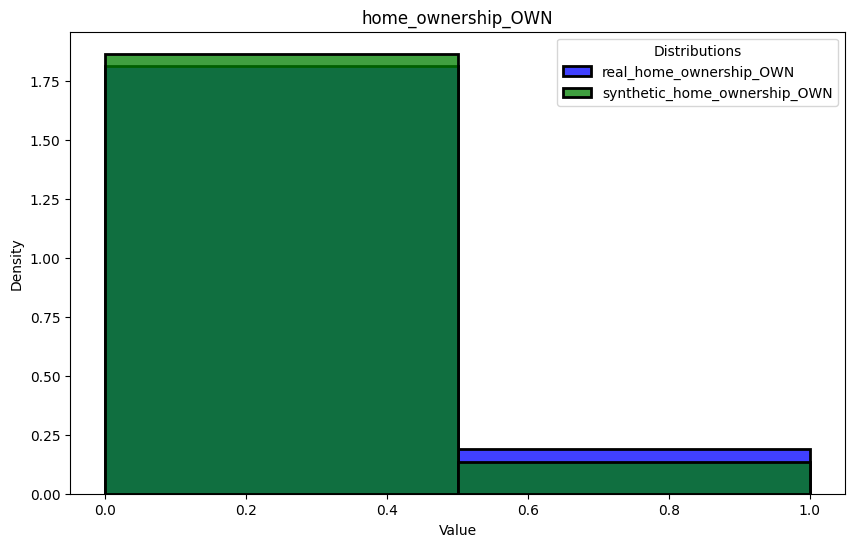

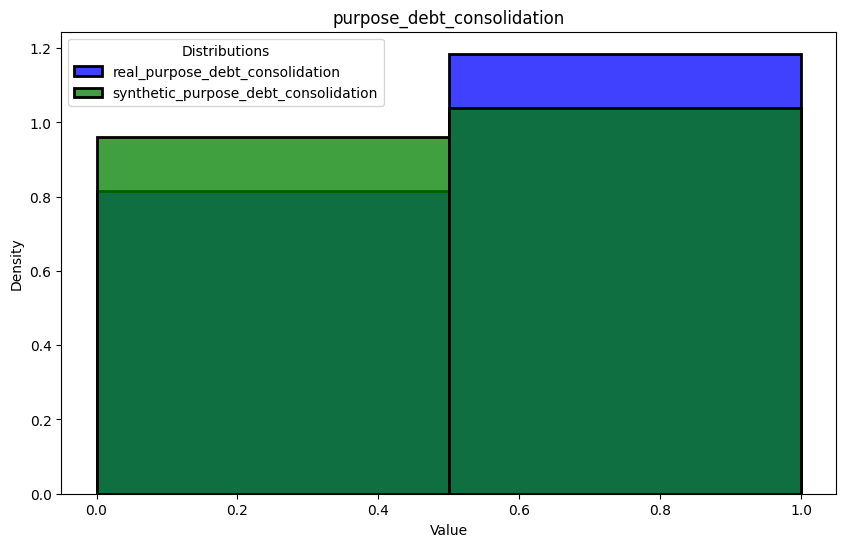

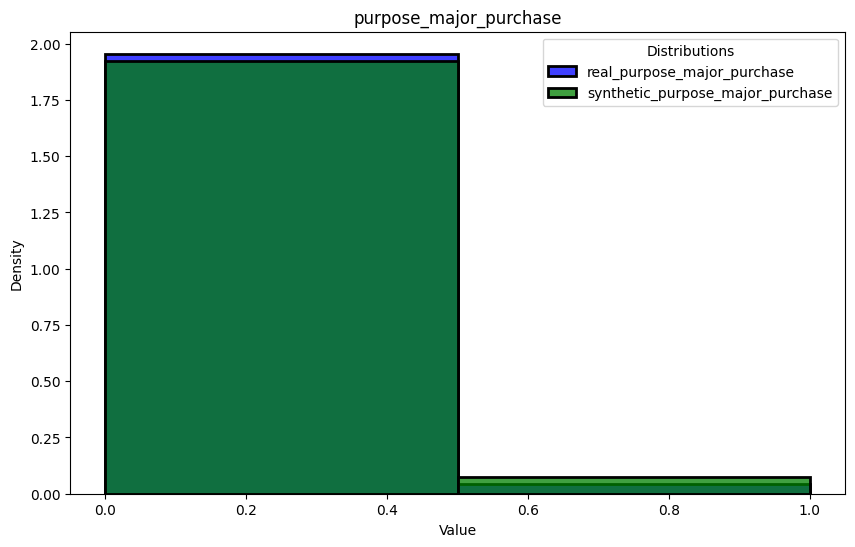

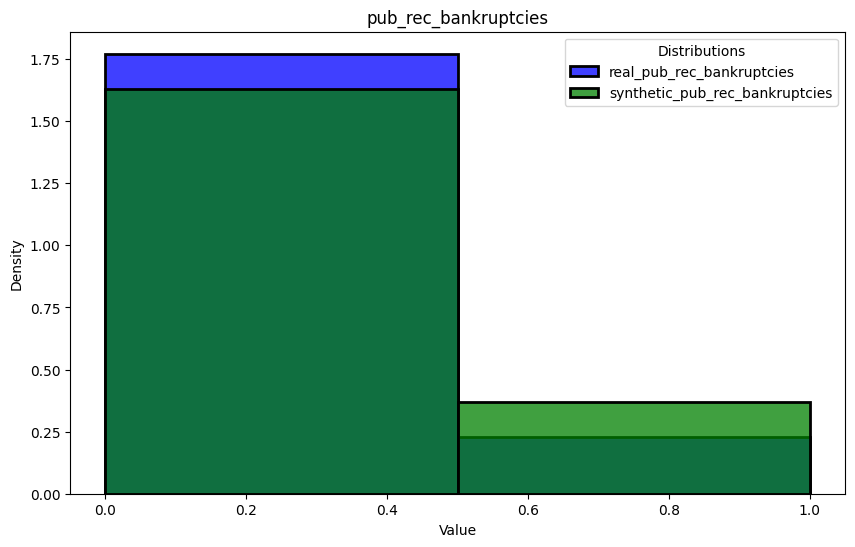

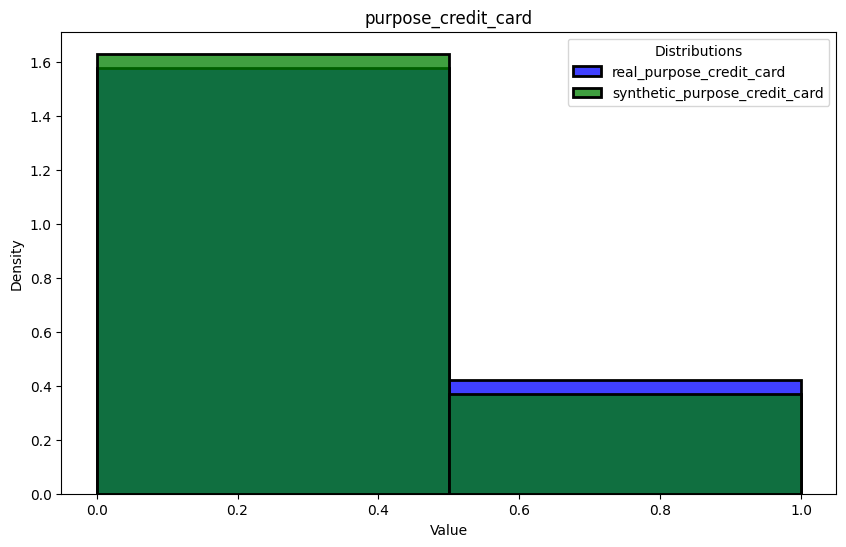

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



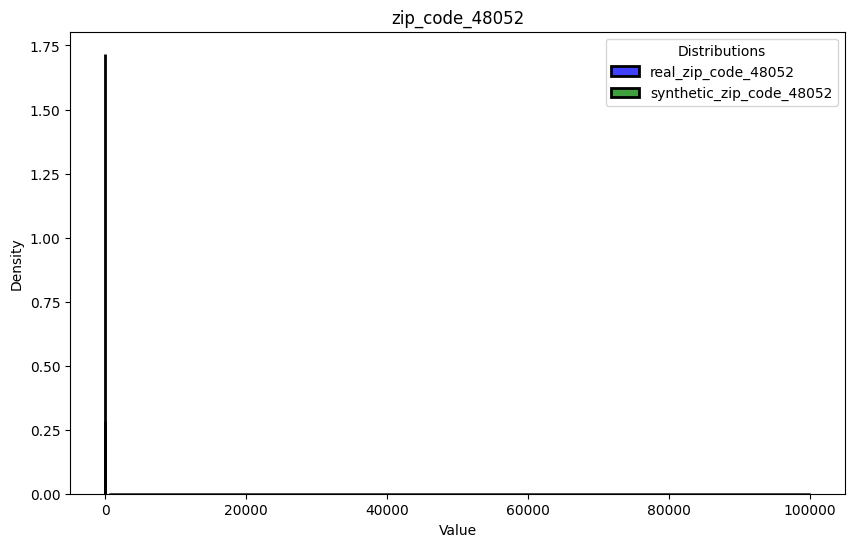

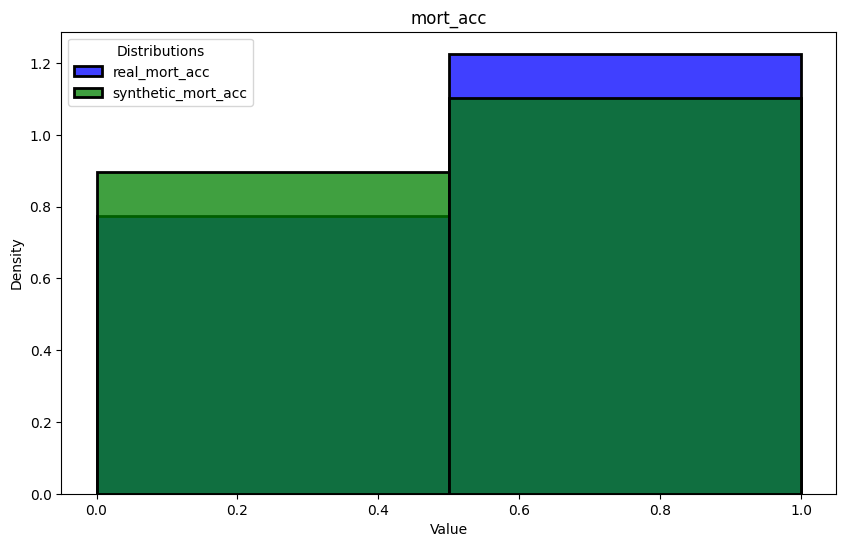

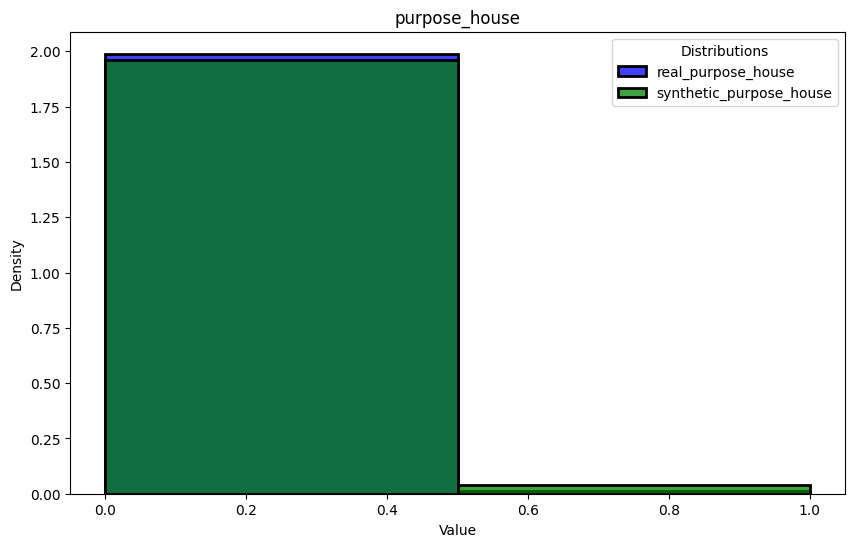

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



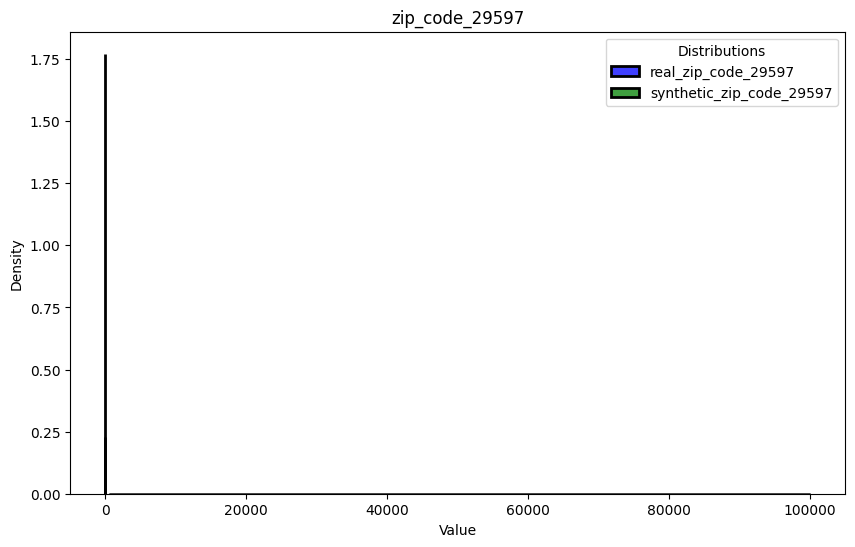

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



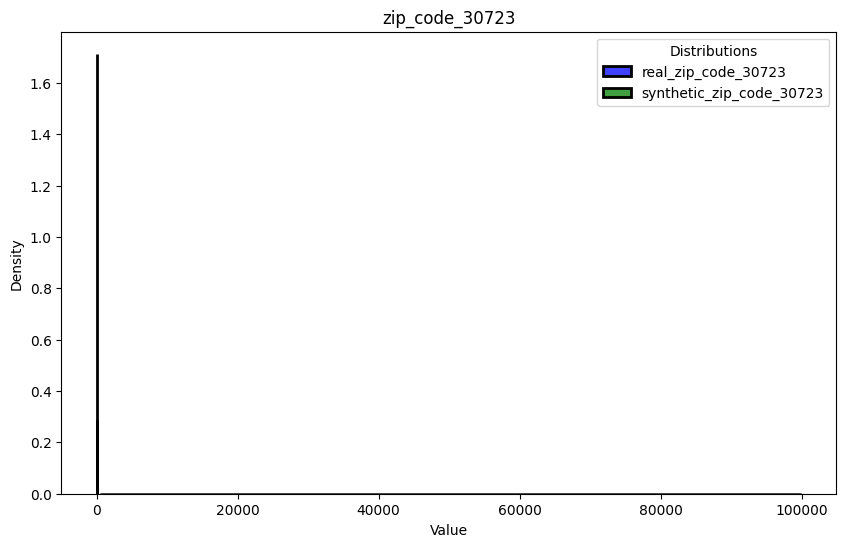

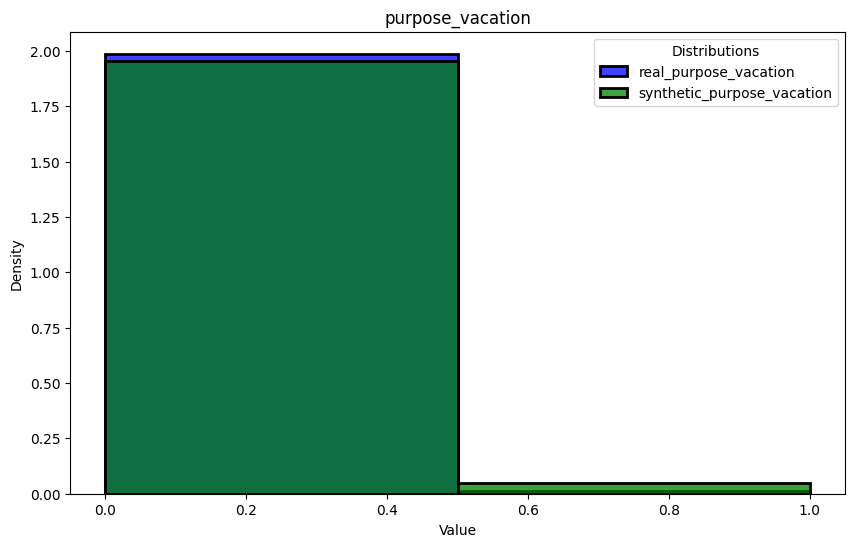

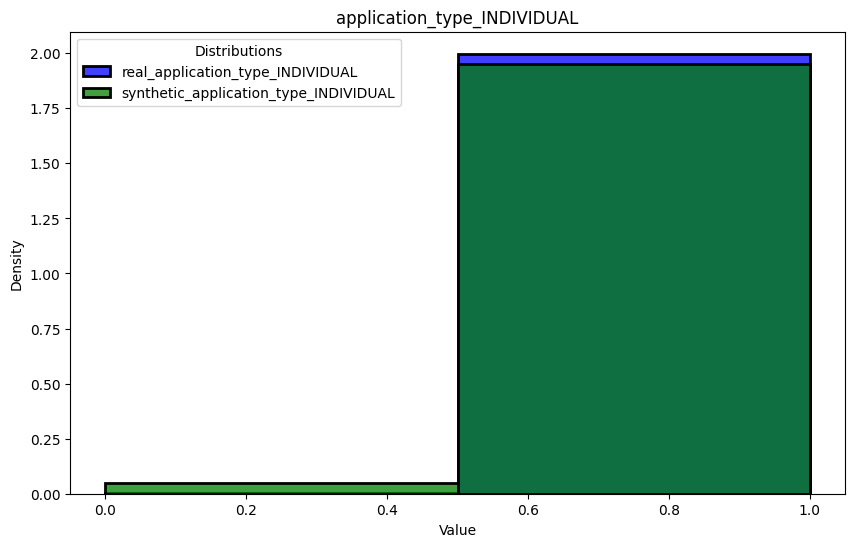

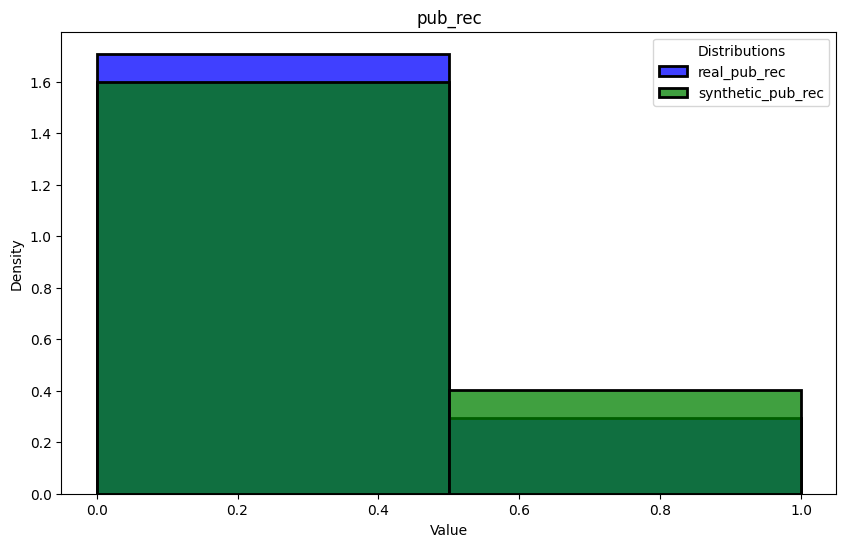

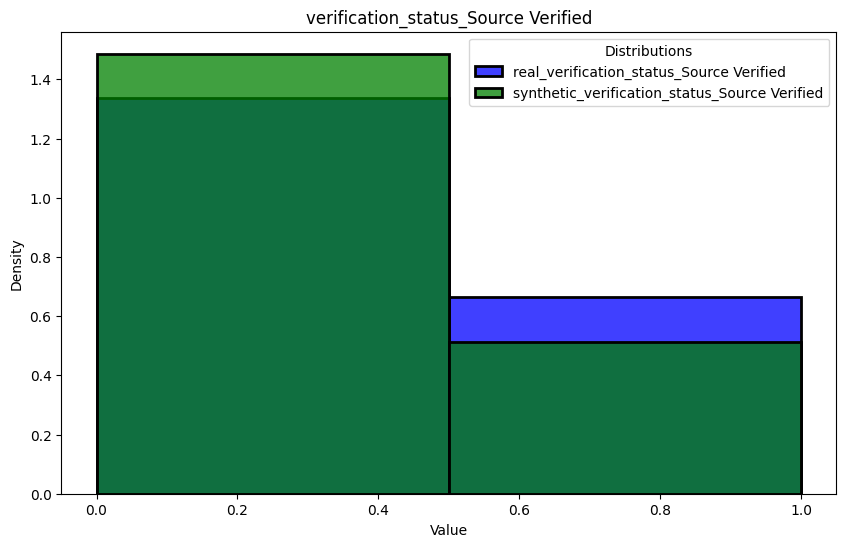

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



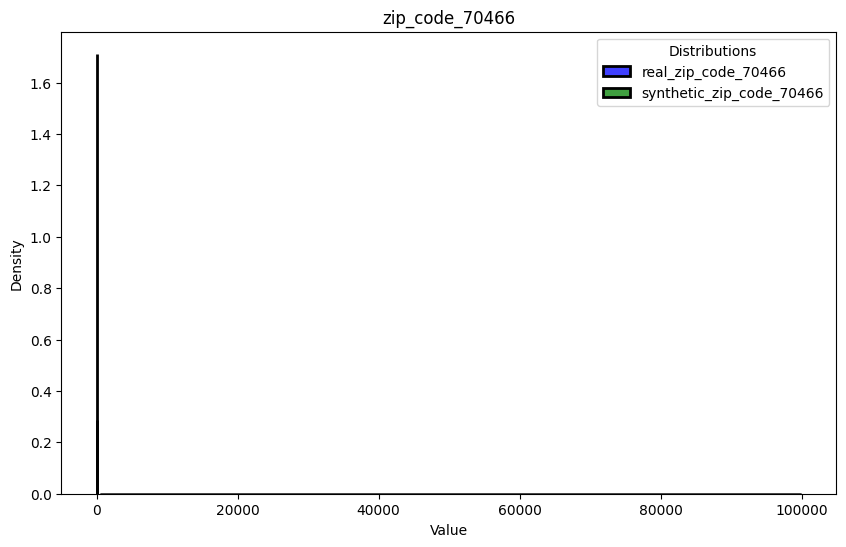

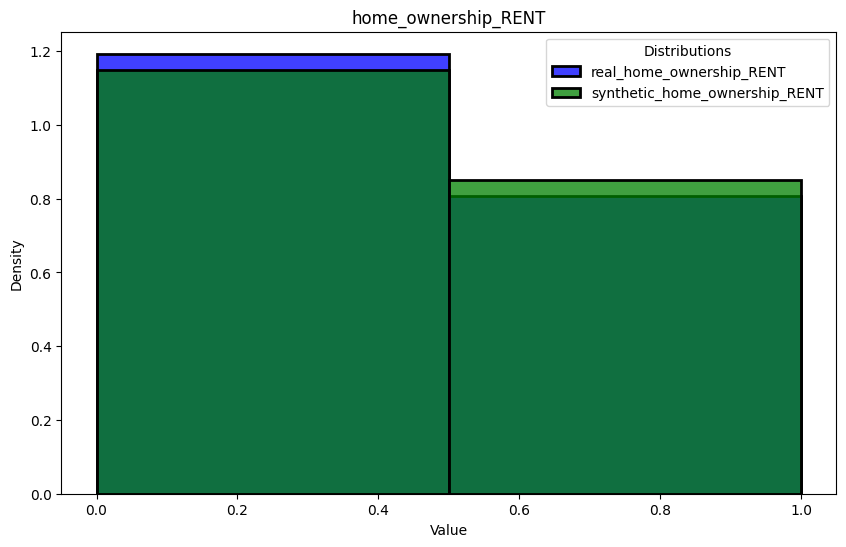

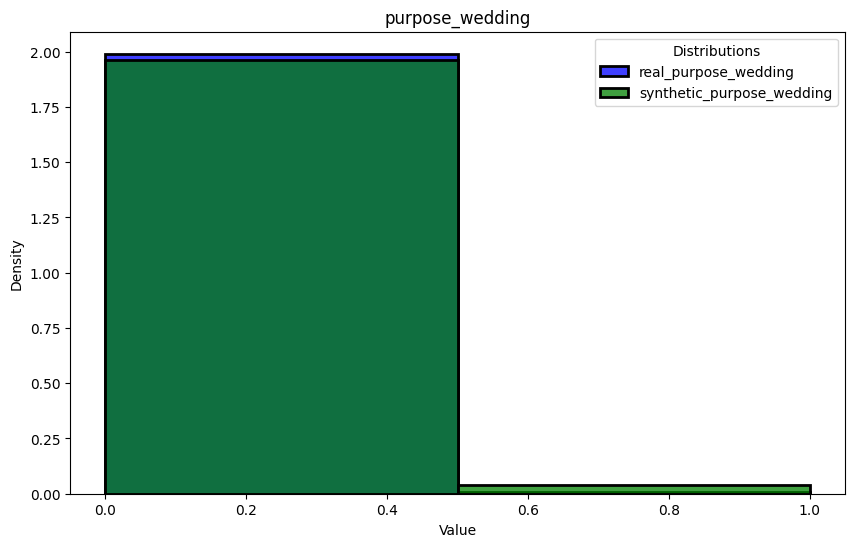

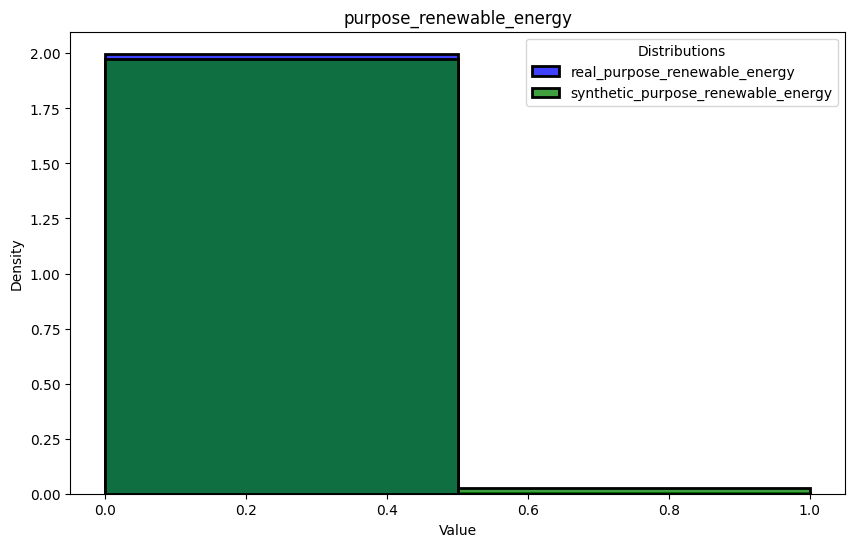

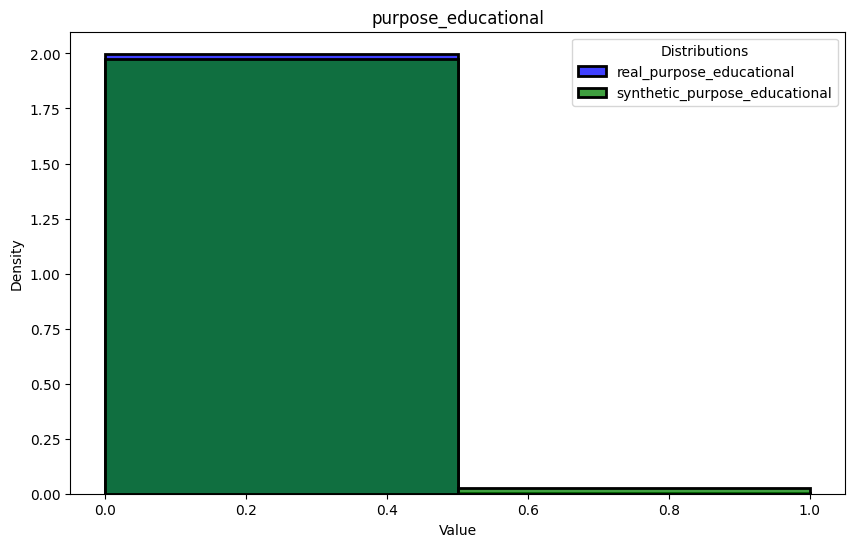

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



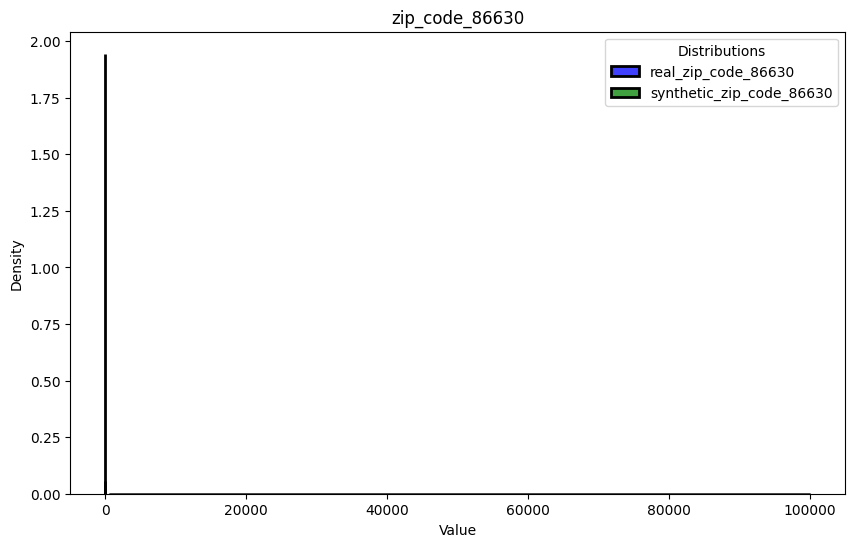

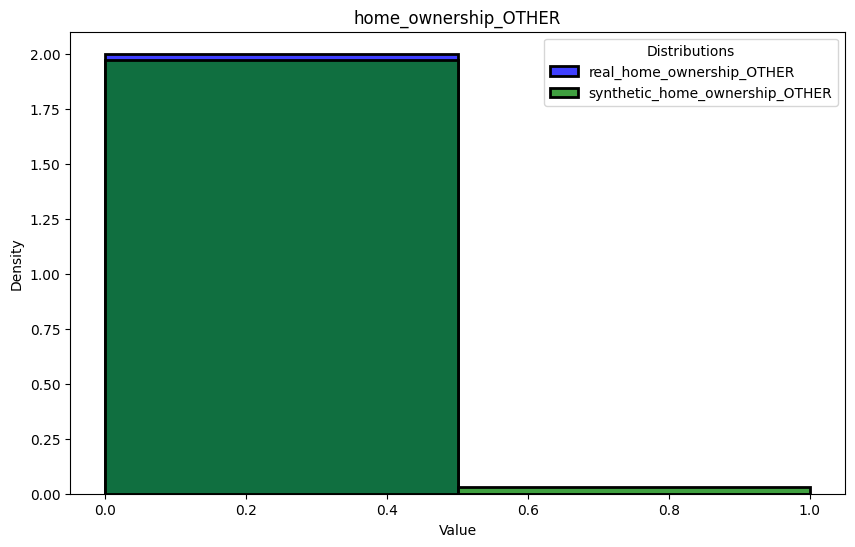

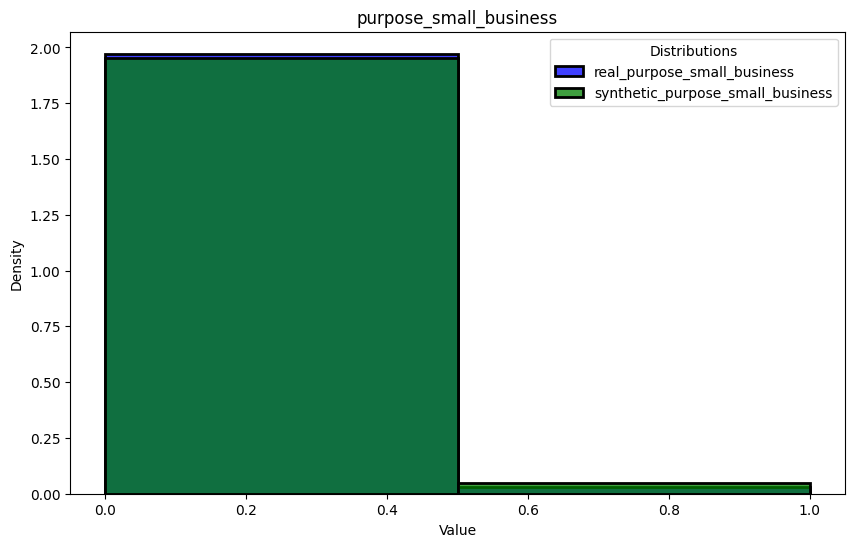

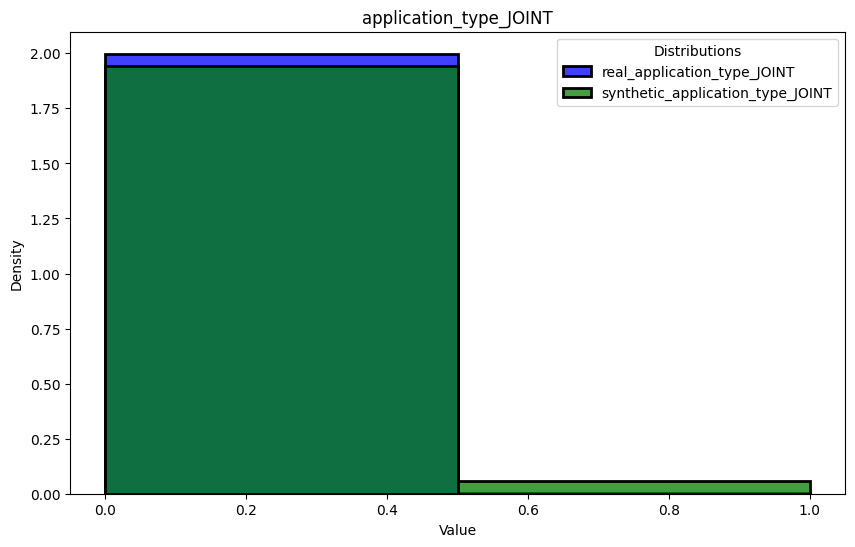

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



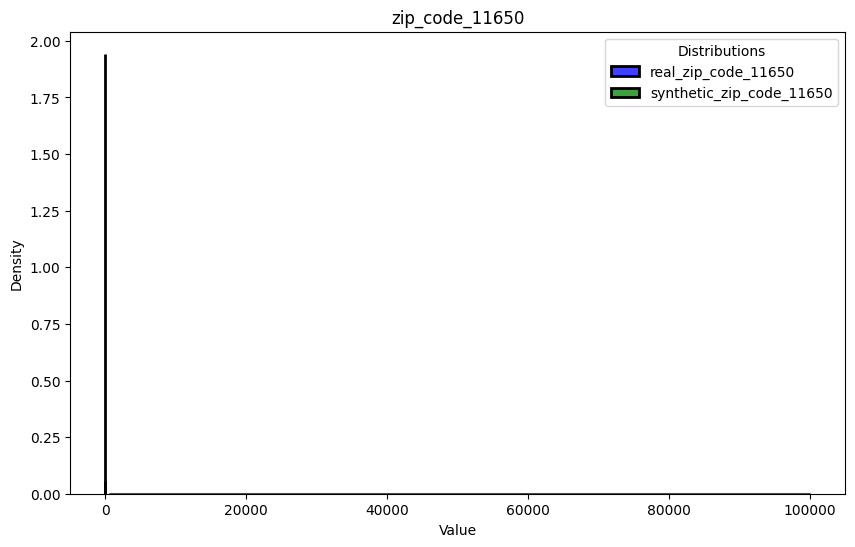

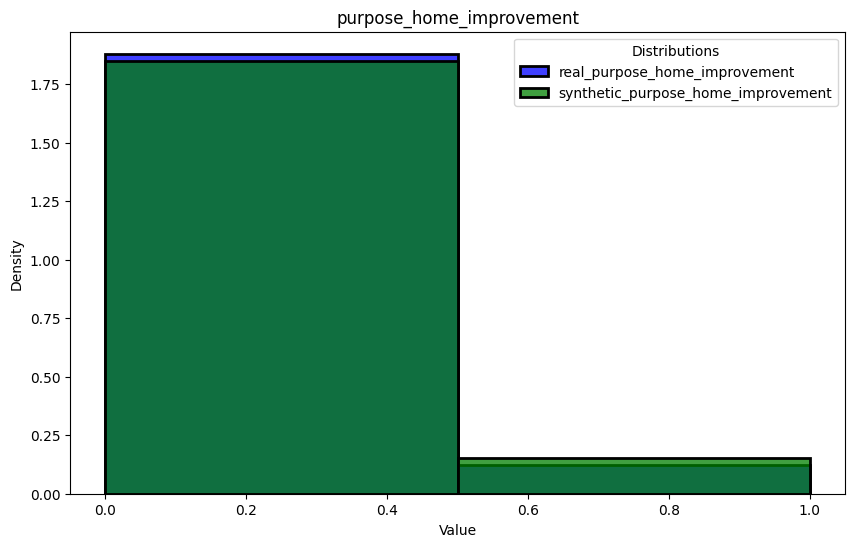

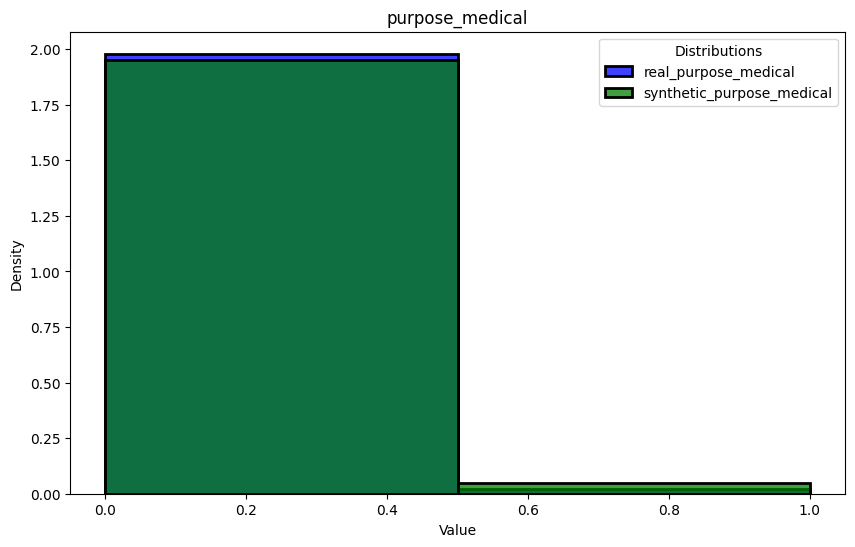

In [110]:
for feature in discrete_columns:
    plt.figure(figsize=(10, 6))

    # Строим распределение для признака из df1 и df2
    sns.histplot(X_train_cut[feature], color='blue', label=f'real_{feature}', stat='density',
                 linewidth=2, bins = X_train_cut[feature].nunique())
    sns.histplot(synthetic_data[feature], color='green', label=f'synthetic_{feature}', stat='density',
                 linewidth=2, bins = synthetic_data[feature].nunique())

    # Добавляем легенду, подписи осей и заголовок
    plt.legend(title='Distributions')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(feature)

    # Отображаем график
    plt.show()

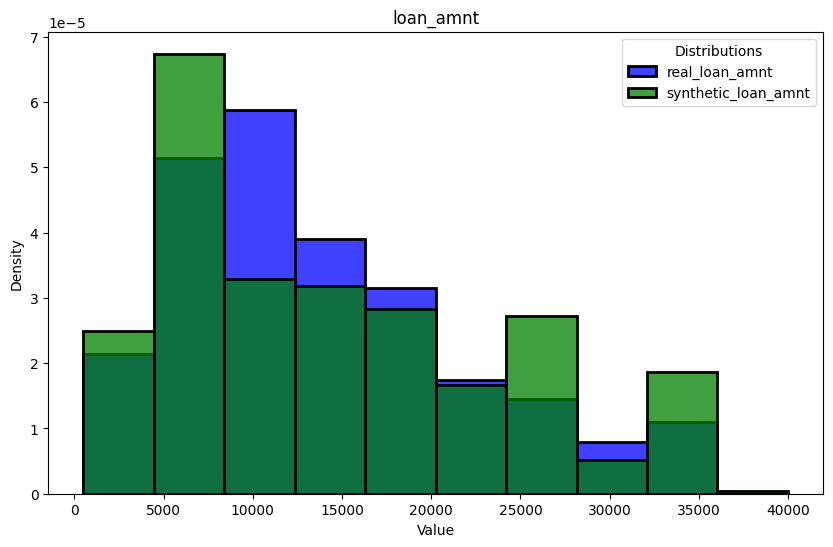

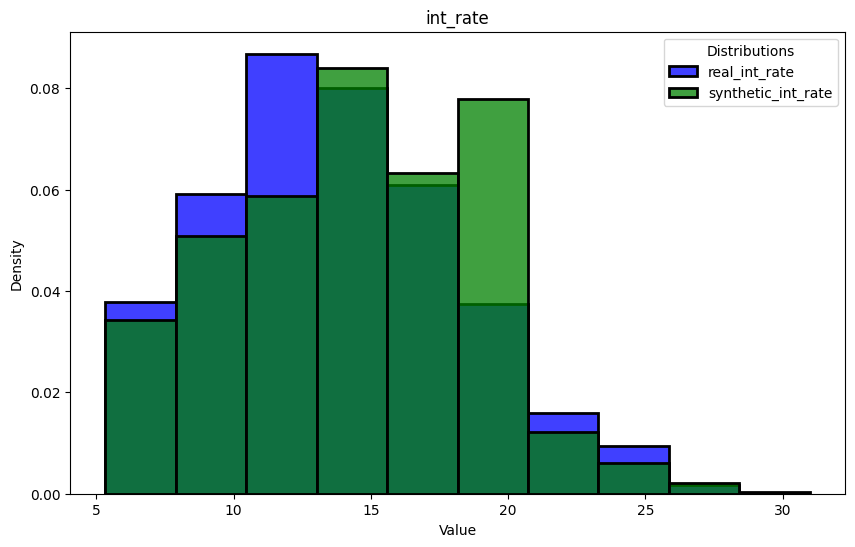

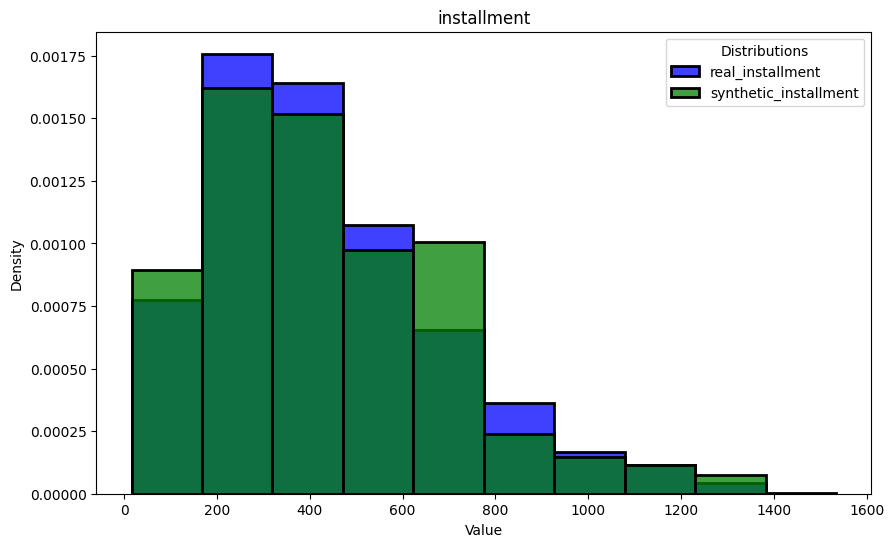

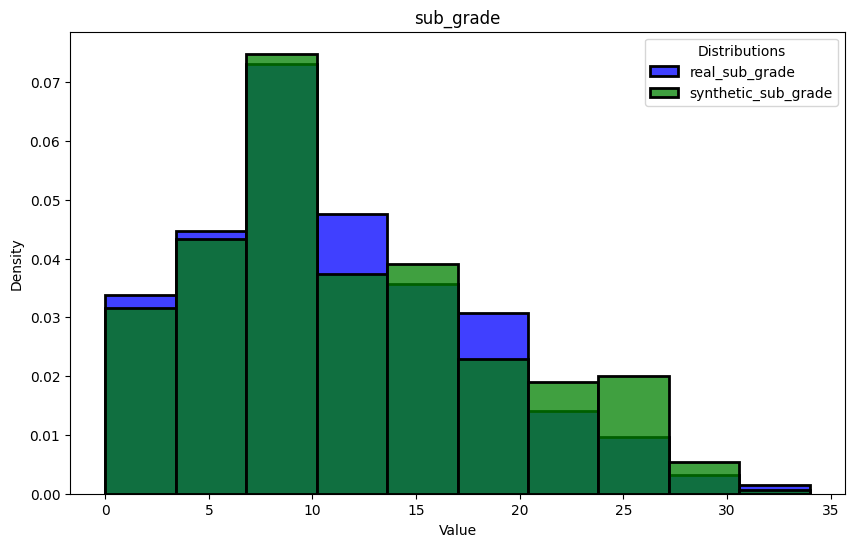

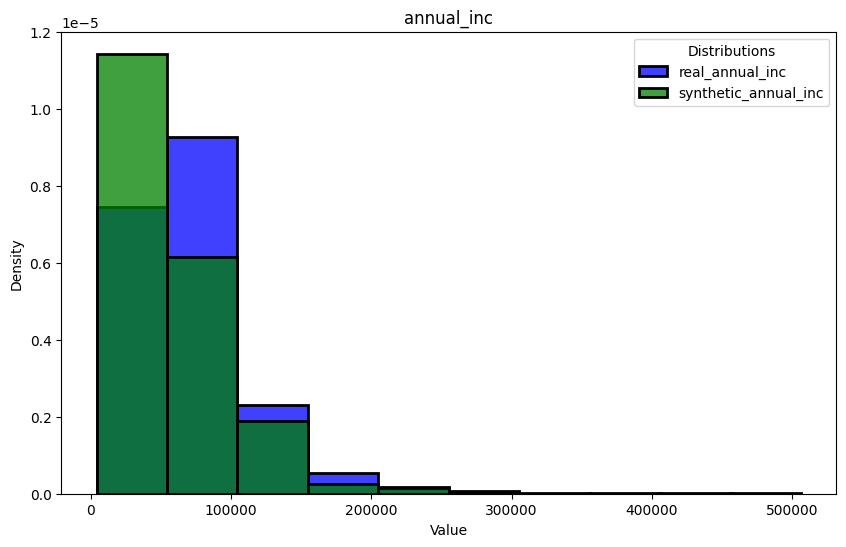

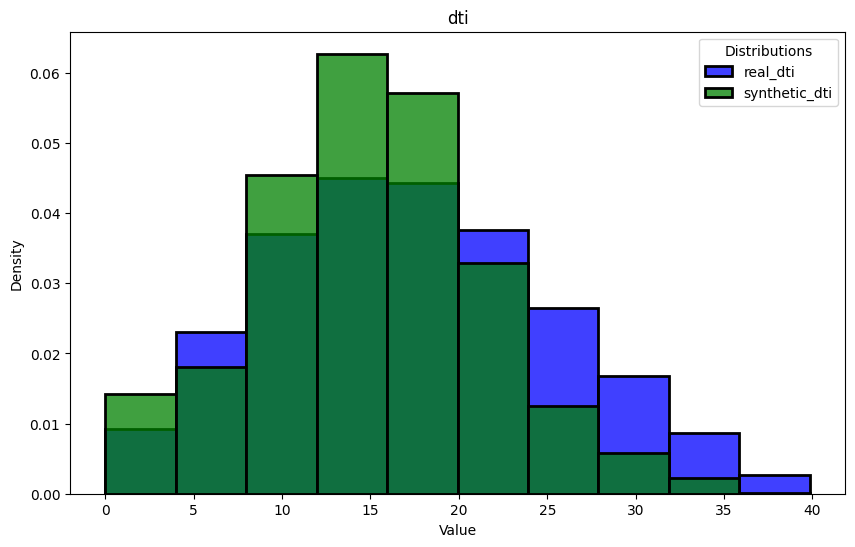

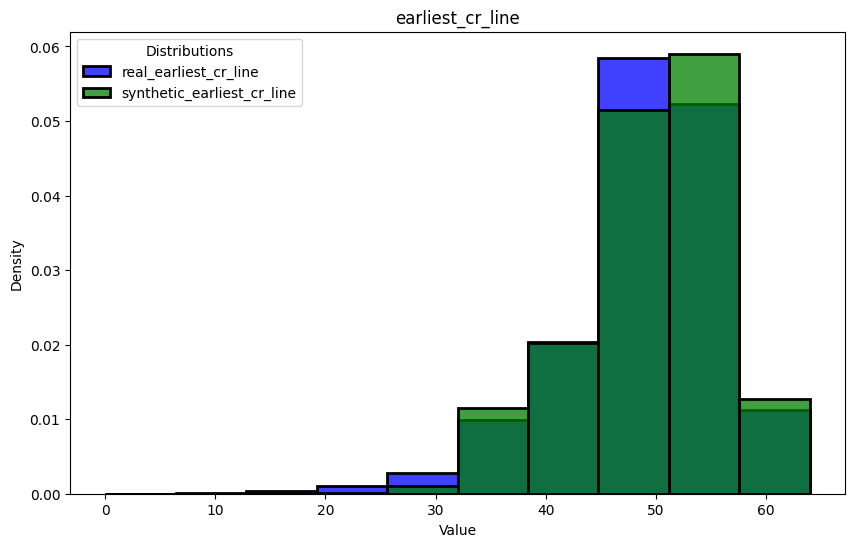

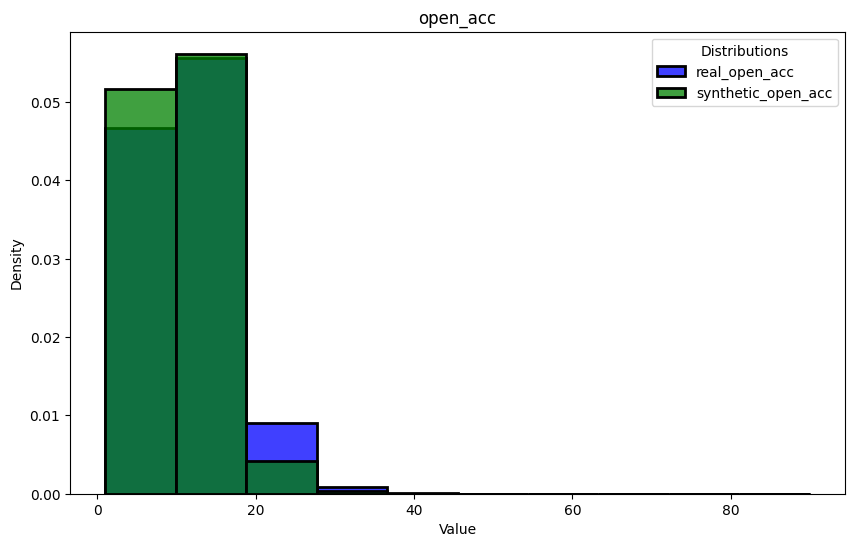

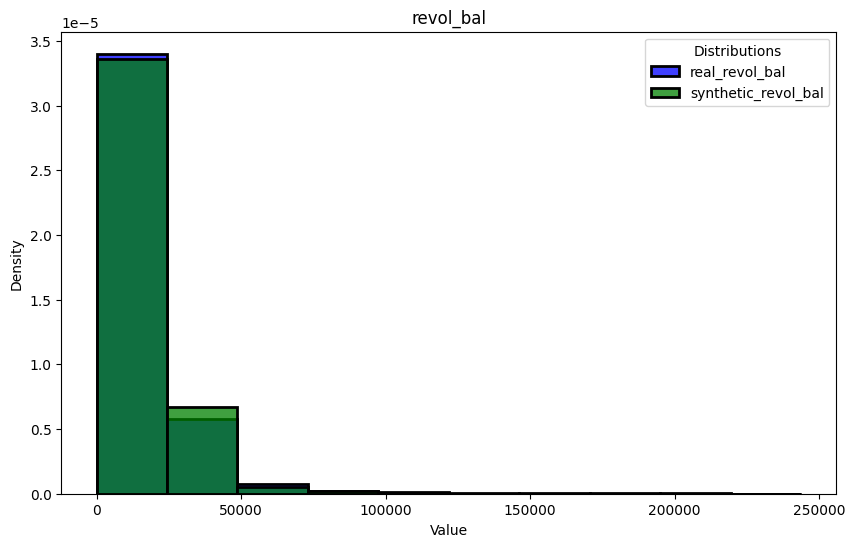

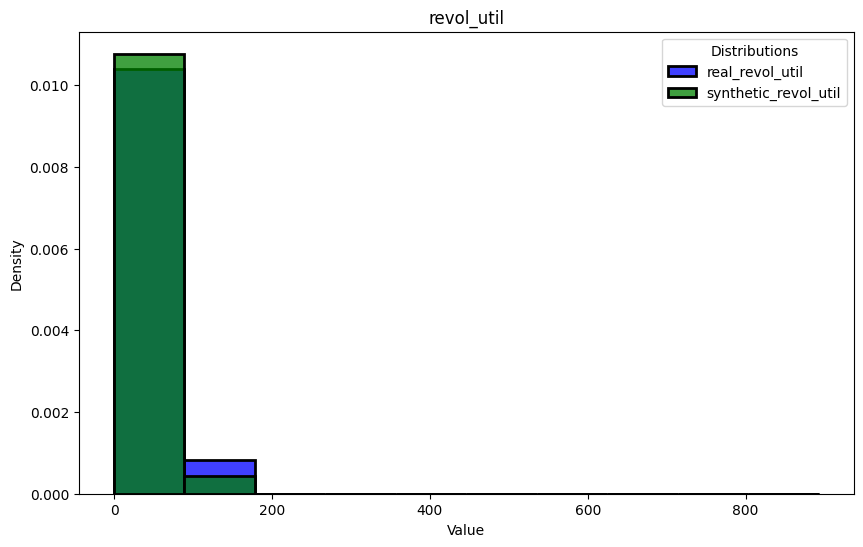

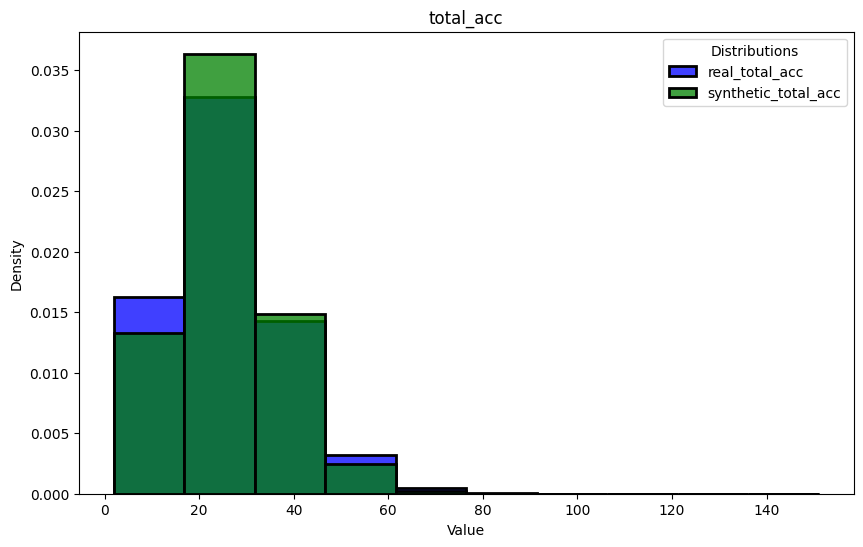

In [111]:
for feature in cont_columns:
    plt.figure(figsize=(10, 6))

    # Строим распределение для признака из df1 и df2
    sns.histplot(X_train_cut[feature], color='blue', label=f'real_{feature}', stat='density',
                 linewidth=2, binrange = (X_train_cut[feature].min(), X_train_cut[feature].max()),
             binwidth = (X_train_cut[feature].max() - X_train_cut[feature].min()) / 10)
    sns.histplot(synthetic_data[feature], color='green', label=f'synthetic_{feature}', stat='density',
                linewidth=2, binrange = (X_train_cut[feature].min(), X_train_cut[feature].max()),
             binwidth = (X_train_cut[feature].max() - X_train_cut[feature].min()) / 10)

    # Добавляем легенду, подписи осей и заголовок
    plt.legend(title='Distributions')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(feature)

    # Отображаем график
    plt.show()

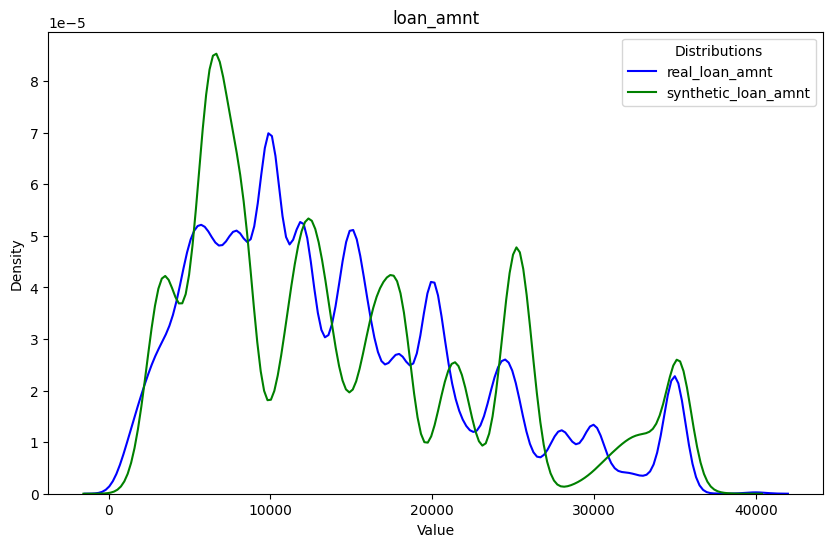

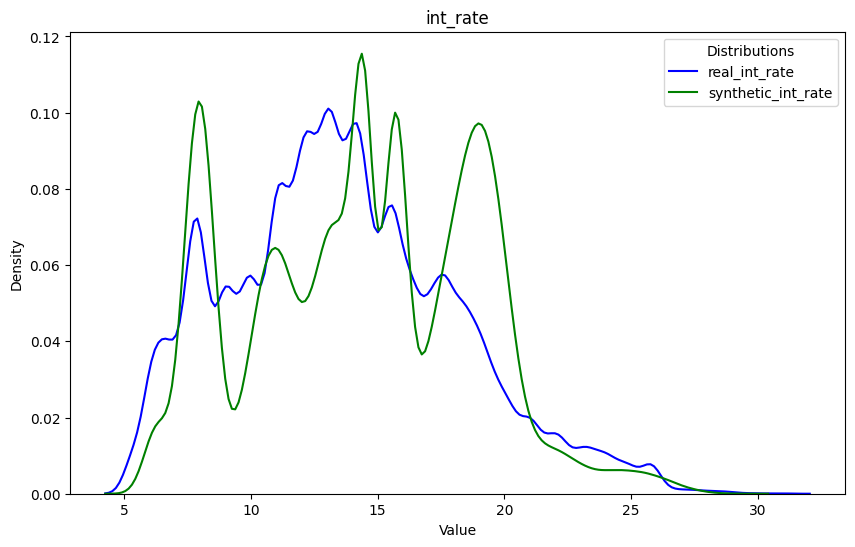

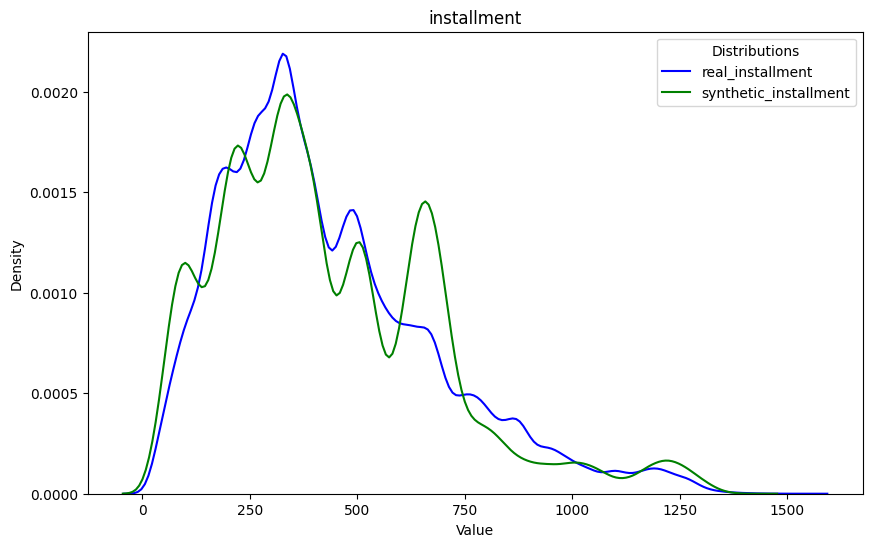

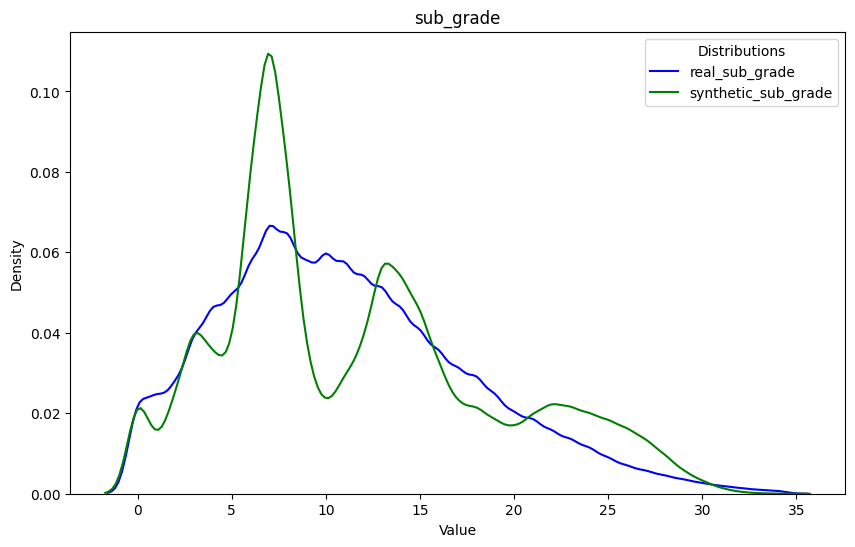

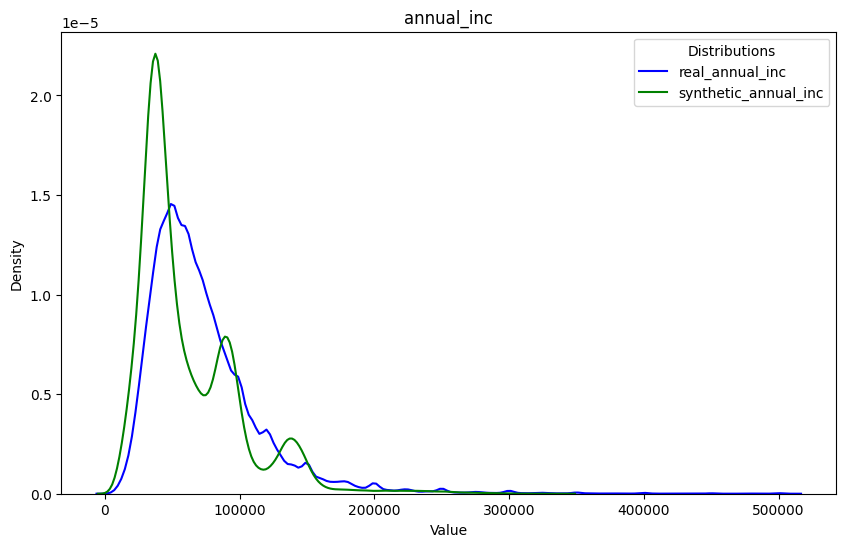

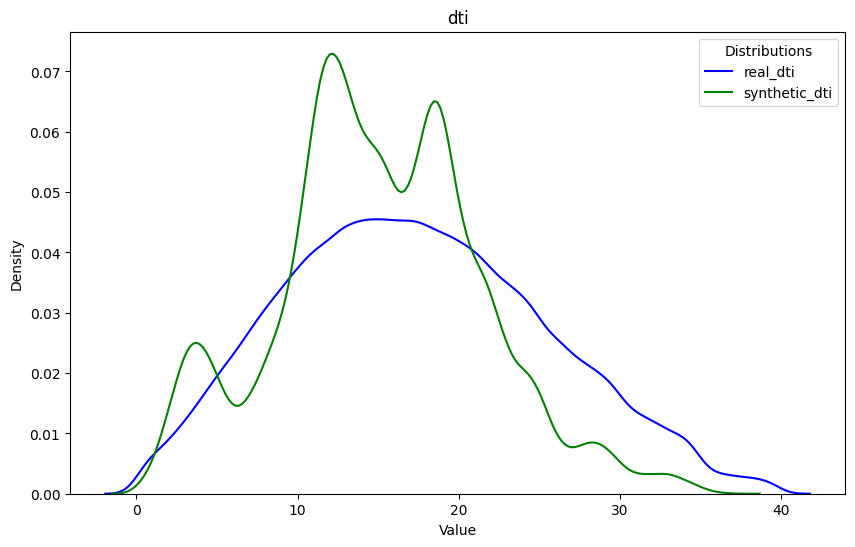

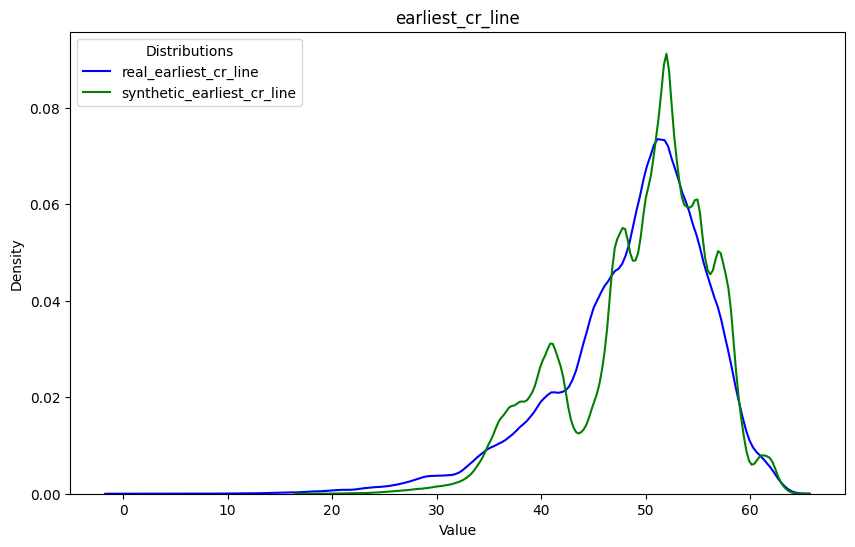

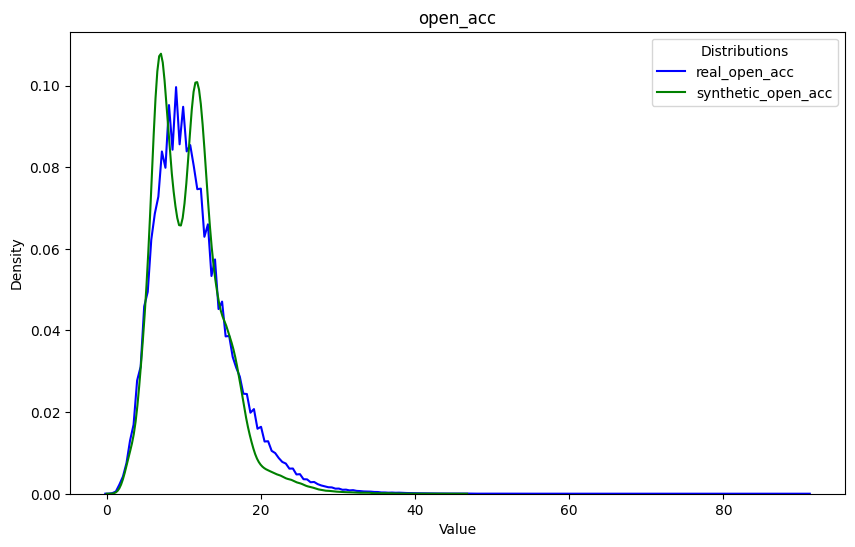

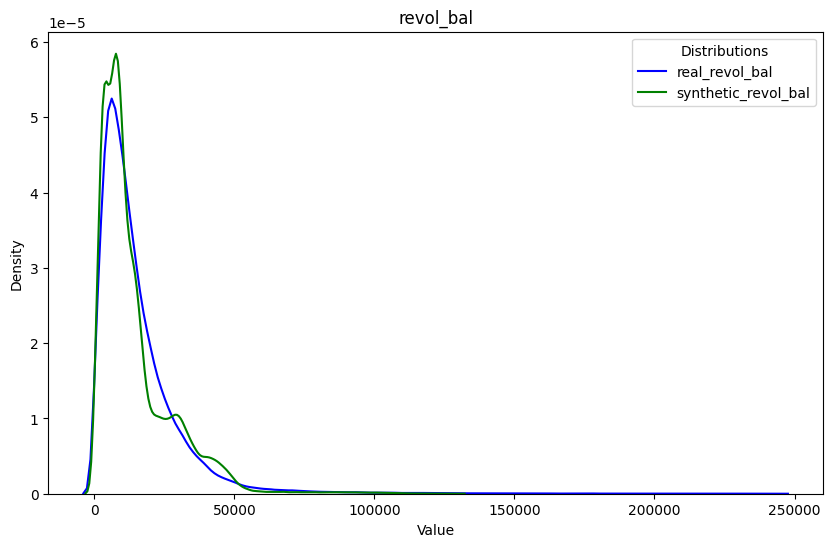

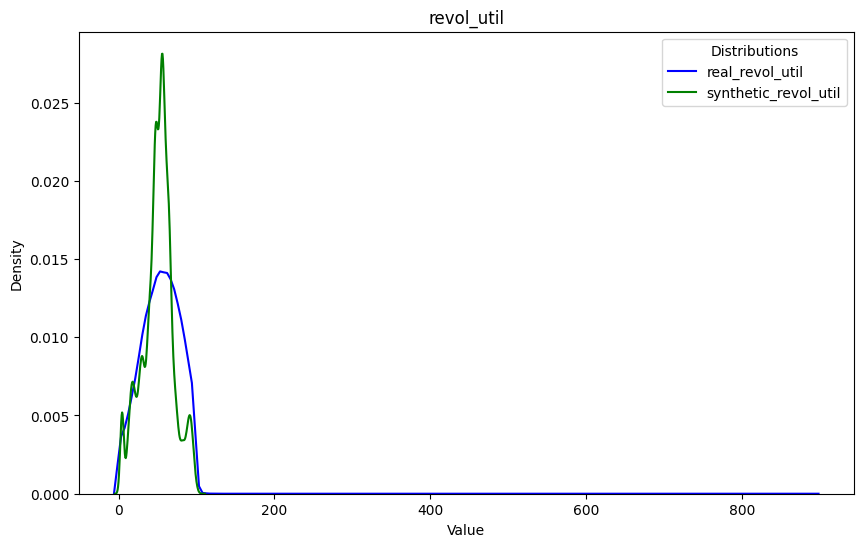

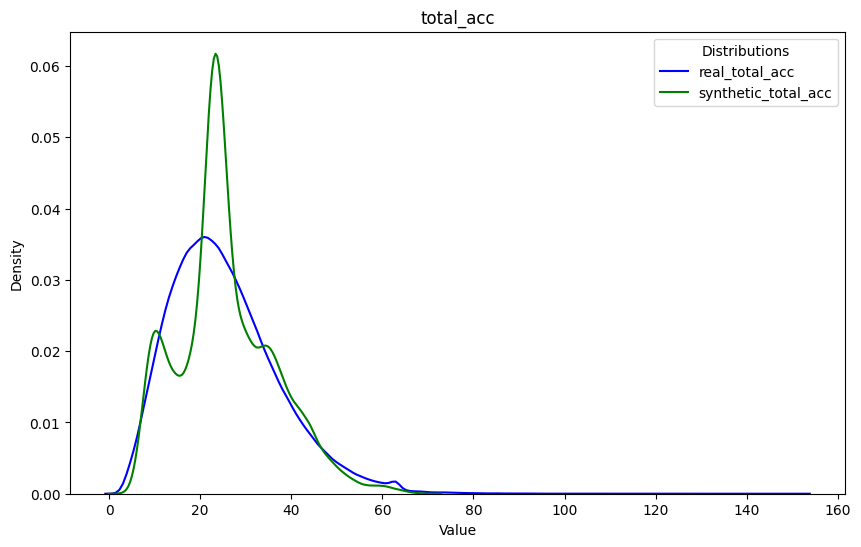

In [112]:
for feature in cont_columns:
    plt.figure(figsize=(10, 6))

    # Строим распределение для признака из df1 и df2
    sns.kdeplot(X_train_cut[feature], color='blue', label=f'real_{feature}')
    sns.kdeplot(synthetic_data[feature], color='green', label=f'synthetic_{feature}')

    # Добавляем легенду, подписи осей и заголовок
    plt.legend(title='Distributions')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(feature)

    # Отображаем график
    plt.show()